In [1]:
#important python libraries
import pandas as pd
import numpy as np
import os

#for visualisation
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

#for sentiment analysis
from textblob import TextBlob

#for text modelling
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Preprocess Data

In [2]:
#load data
text_path = 'C:/Users/nuhamin/Documents/kifiya/week 1/' \
'Stock-Market-Price-Prediction-with-Sentiment-Analysis/' \
'data/raw_analyst_ratings.csv'

try:
    text_data = pd.read_csv (text_path, engine='python')
    print ('File loaded sucessfully')
    print(text_data.head())
except FileNotFoundError:
    print (f"Error: The file path '{text_path}' was not found.")
except Exception as e:
    print (f'An error occurred while loading file: {e}')

File loaded sucessfully
   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4           4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer   

                        date stock  
0  2020-06-05 10:30:54-04:00     A  
1  2020-06-03 10:45:20-04:00     A  
2  20

In [3]:
#select stock tickers
tickers = ['AAPL', 'AMZN', 'GOOG', 'FB', 'MSF', 'NVDA', 'TSLA']

#filter text_data dataframe to include rows where the 'stock' column is in the 'tickers' list
#drop 'Unnamed: 0'column, reset and drop old index, and sort index
stock_news = text_data[text_data['stock'].isin(tickers)].drop('Unnamed: 0', 
                                                              axis='columns').reset_index(drop=True).sort_index(axis=1)

#print the head of the resulting dataframe
stock_news.head()

,date,headline,publisher,stock,url
0,2020-06-10 11:33:26-04:00,Tech Stocks And FAANGS Strong Again To Start D...,JJ Kinahan,AAPL,https://www.benzinga.com/government/20/06/1622...
1,2020-06-10 08:14:08-04:00,10 Biggest Price Target Changes For Wednesday,Lisa Levin,AAPL,https://www.benzinga.com/analyst-ratings/price...
2,2020-06-10 07:53:47-04:00,"Benzinga Pro's Top 5 Stocks To Watch For Wed.,...",Benzinga Newsdesk,AAPL,https://www.benzinga.com/short-sellers/20/06/1...
3,2020-06-10 07:19:25-04:00,"Deutsche Bank Maintains Buy on Apple, Raises P...",Benzinga Newsdesk,AAPL,https://www.benzinga.com/news/20/06/16219873/d...
4,2020-06-10 06:27:11-04:00,Apple To Let Users Trade In Their Mac Computer...,Neer Varshney,AAPL,https://www.benzinga.com/news/20/06/16218697/a...


In [4]:
#print the tail of the resulting dataframe
stock_news.tail()

,date,headline,publisher,stock,url
7326,2019-07-02 00:00:00,Electrek.Co Tweet: Tesla's head of Europe is out,Charles Gross,TSLA,https://www.benzinga.com/news/19/07/14015998/e...
7327,2019-07-01 00:00:00,Tesla's Q2 Delivery Number Could Cause A Big Move,Wayne Duggan,TSLA,https://www.benzinga.com/analyst-ratings/analy...
7328,2019-07-01 00:00:00,'Tesla Electric Airplane? Elon Musk sees elect...,Benzinga Newsdesk,TSLA,https://www.benzinga.com/news/19/07/14011389/t...
7329,2019-07-01 00:00:00,"UPDATE: JMP Reiterates Outperform, $347 Target...",Benzinga_Newsdesk,TSLA,https://www.benzinga.com/analyst-ratings/analy...
7330,2019-07-01 00:00:00,Tesla shares are trading higher after JMP Secu...,Hal Lindon,TSLA,https://www.benzinga.com/markets/wiim/19/07/14...


In [5]:
#Pass `format='ISO8601'` to change some date formats that are `'format='%Y-%m-%d %0:%0:%0%0'
stock_news['date'] = pd.to_datetime(stock_news['date'], 
                                 format='ISO8601', errors='coerce')
stock_news.tail()

,date,headline,publisher,stock,url
7326,2019-07-02 00:00:00-04:00,Electrek.Co Tweet: Tesla's head of Europe is out,Charles Gross,TSLA,https://www.benzinga.com/news/19/07/14015998/e...
7327,2019-07-01 00:00:00-04:00,Tesla's Q2 Delivery Number Could Cause A Big Move,Wayne Duggan,TSLA,https://www.benzinga.com/analyst-ratings/analy...
7328,2019-07-01 00:00:00-04:00,'Tesla Electric Airplane? Elon Musk sees elect...,Benzinga Newsdesk,TSLA,https://www.benzinga.com/news/19/07/14011389/t...
7329,2019-07-01 00:00:00-04:00,"UPDATE: JMP Reiterates Outperform, $347 Target...",Benzinga_Newsdesk,TSLA,https://www.benzinga.com/analyst-ratings/analy...
7330,2019-07-01 00:00:00-04:00,Tesla shares are trading higher after JMP Secu...,Hal Lindon,TSLA,https://www.benzinga.com/markets/wiim/19/07/14...


In [6]:
#check the infromation of the dataframe
print ('DataFrame Information:\n')
stock_news.info()

print ('\nDataFrame Shape:')
stock_news.shape

DataFrame Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7331 entries, 0 to 7330
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype                    
---  ------     --------------  -----                    
 0   date       7331 non-null   datetime64[ns, UTC-04:00]
 1   headline   7331 non-null   object                   
 2   publisher  7331 non-null   object                   
 3   stock      7331 non-null   object                   
 4   url        7331 non-null   object                   
dtypes: datetime64[ns, UTC-04:00](1), object(4)
memory usage: 286.5+ KB

DataFrame Shape:


(7331, 5)

## Sentiment Analysis

In [7]:
#define a function to calculate sentiment polarity using TextBlob
def calculate_sentiment(text):
    return TextBlob(text).sentiment.polarity

#apply the sentiment analysis function to selected stock headlines
stock_news['sentiment'] = stock_news['headline'].apply(calculate_sentiment)
stock_news

,date,headline,publisher,stock,url,sentiment
0,2020-06-10 11:33:26-04:00,Tech Stocks And FAANGS Strong Again To Start D...,JJ Kinahan,AAPL,https://www.benzinga.com/government/20/06/1622...,0.433333
1,2020-06-10 08:14:08-04:00,10 Biggest Price Target Changes For Wednesday,Lisa Levin,AAPL,https://www.benzinga.com/analyst-ratings/price...,0.000000
2,2020-06-10 07:53:47-04:00,"Benzinga Pro's Top 5 Stocks To Watch For Wed.,...",Benzinga Newsdesk,AAPL,https://www.benzinga.com/short-sellers/20/06/1...,0.500000
3,2020-06-10 07:19:25-04:00,"Deutsche Bank Maintains Buy on Apple, Raises P...",Benzinga Newsdesk,AAPL,https://www.benzinga.com/news/20/06/16219873/d...,0.000000
4,2020-06-10 06:27:11-04:00,Apple To Let Users Trade In Their Mac Computer...,Neer Varshney,AAPL,https://www.benzinga.com/news/20/06/16218697/a...,0.000000
...,...,...,...,...,...,...
7326,2019-07-02 00:00:00-04:00,Electrek.Co Tweet: Tesla's head of Europe is out,Charles Gross,TSLA,https://www.benzinga.com/news/19/07/14015998/e...,0.000000
7327,2019-07-01 00:00:00-04:00,Tesla's Q2 Delivery Number Could Cause A Big Move,Wayne Duggan,TSLA,https://www.benzinga.com/analyst-ratings/analy...,0.000000
7328,2019-07-01 00:00:00-04:00,'Tesla Electric Airplane? Elon Musk sees elect...,Benzinga Newsdesk,TSLA,https://www.benzinga.com/news/19/07/14011389/t...,0.000000
7329,2019-07-01 00:00:00-04:00,"UPDATE: JMP Reiterates Outperform, $347 Target...",Benzinga_Newsdesk,TSLA,https://www.benzinga.com/analyst-ratings/analy...,0.066667


In [8]:
#initialise an empty dictionary to store dataframes for each stock ticker
stock_dfs = {}

#iterate through the list of tickers
for ticker in tickers:
  stock_dfs[ticker] = stock_news[stock_news['stock'].isin([ticker])].reset_index(drop=True)

## Topic Modelling

In [9]:
#download necessary NLTK data
nltk.download('punkt')              #splits text
nltk.download('stopwords')          #removes common words like 'a', 'is', 'the', 'in'
nltk.download('wordnet')            #identifies synonyms
#nltk.download('punkt_tab')

#load spacy English model
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("Downloading spacy model 'en_core_web_sm'...")
    from spacy.cli import download
    download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nuhamin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nuhamin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nuhamin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# **AAPL**

In [10]:
#assign df to a variable and display head
AAPL_df = stock_dfs['AAPL']
AAPL_df.head()

,date,headline,publisher,stock,url,sentiment
0,2020-06-10 11:33:26-04:00,Tech Stocks And FAANGS Strong Again To Start D...,JJ Kinahan,AAPL,https://www.benzinga.com/government/20/06/1622...,0.433333
1,2020-06-10 08:14:08-04:00,10 Biggest Price Target Changes For Wednesday,Lisa Levin,AAPL,https://www.benzinga.com/analyst-ratings/price...,0.000000
2,2020-06-10 07:53:47-04:00,"Benzinga Pro's Top 5 Stocks To Watch For Wed.,...",Benzinga Newsdesk,AAPL,https://www.benzinga.com/short-sellers/20/06/1...,0.500000
3,2020-06-10 07:19:25-04:00,"Deutsche Bank Maintains Buy on Apple, Raises P...",Benzinga Newsdesk,AAPL,https://www.benzinga.com/news/20/06/16219873/d...,0.000000
4,2020-06-10 06:27:11-04:00,Apple To Let Users Trade In Their Mac Computer...,Neer Varshney,AAPL,https://www.benzinga.com/news/20/06/16218697/a...,0.000000


## Descrptive Statistics

In [11]:
#display descriptive statistics for the 'headline' column
print("Descriptive statistics for 'headline' column:")
print(AAPL_df['headline'].describe())

#get the number of unique headlines
print('\nNumber of unique headlines:')
print(AAPL_df['headline'].nunique())

#calculate headline length
AAPL_df['headline_length'] = AAPL_df['headline'].apply(len)
print("\nBasic statistics for 'headline_length' column:")
print(AAPL_df['headline_length'].describe())

#display the most frequent headlines
print('\nMost frequent headlines:')
print(AAPL_df['headline'].value_counts().head())

Descriptive statistics for 'headline' column:
count                                            441
unique                                           435
top       10 Biggest Price Target Changes For Friday
freq                                               3
Name: headline, dtype: object

Number of unique headlines:
435

Basic statistics for 'headline_length' column:
count    441.000000
mean      86.997732
std       48.087019
min       21.000000
25%       61.000000
50%       74.000000
75%       92.000000
max      373.000000
Name: headline_length, dtype: float64

Most frequent headlines:
headline
10 Biggest Price Target Changes For Friday                                                                                                                                                                                                              3
Morning Market Stats in 5 Minutes                                                                                                                   

In [12]:
#count the number of articles per publisher 
print('Number of articles per publisher:\n')
print(AAPL_df['publisher'].value_counts())

Number of articles per publisher:

publisher
Benzinga Newsdesk        117
Neer Varshney             47
JJ Kinahan                37
Lisa Levin                32
Charles Gross             25
IAM Newswire              25
Benzinga_Newsdesk         22
Vick Meyer                20
Shivdeep Dhaliwal         20
Shanthi Rexaline          13
Tanzeel Akhtar             9
Nelson Hem                 9
Elizabeth Balboa           8
Jayson Derrick             8
Wayne Duggan               7
Craig Jones                5
Renato Capelj              5
ETF Professor              4
luke@benzinga.com          4
Spencer Israel             3
Jason Shubnell             3
TD Ameritrade              3
FreightWaves               3
Benzinga Insights          2
Henry Khederian            1
Tyree Gorges               1
TD Ameritrade Network      1
Priya Nigam                1
Howie Bick                 1
Othanas Economopoulos      1
Luis Aureliano             1
Luke J Jacobi              1
Benzinga Staff             


Publication trends by day of the week:
publication_day
Wednesday    92
Friday       90
Thursday     82
Tuesday      78
Monday       74
Saturday     13
Sunday       12
Name: count, dtype: int64

Plot is saved.



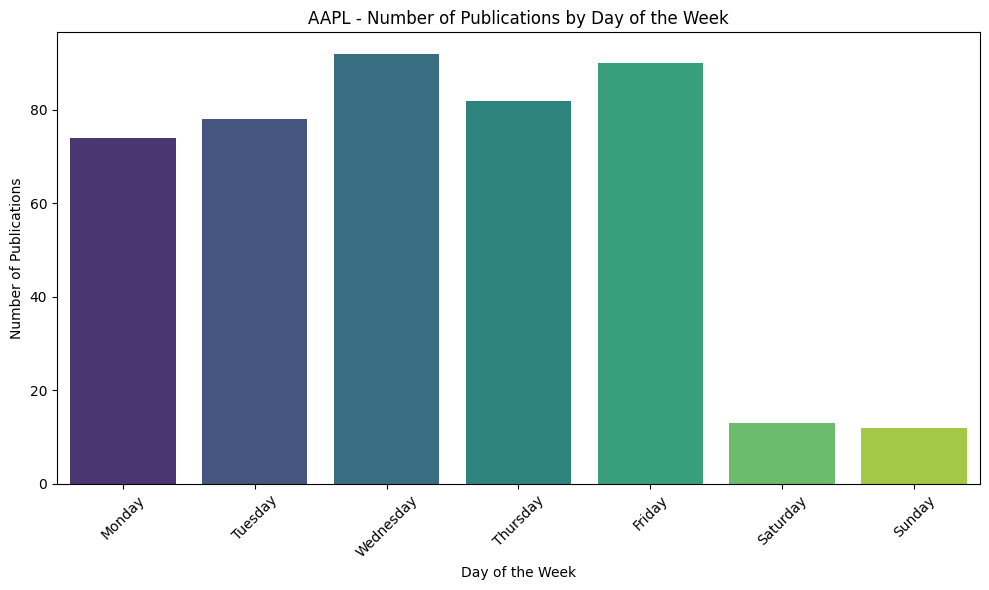

In [13]:
#analyse publication dates
AAPL_df['publication_day'] = AAPL_df['date'].dt.day_name()
print("\nPublication trends by day of the week:")
print(AAPL_df['publication_day'].value_counts())

#plot publication dates and save plot image 
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
publication_day_counts = AAPL_df['publication_day'].value_counts().reindex(day_order)

plt.figure(figsize=(10, 6))
sns.barplot(x=publication_day_counts.index, y=publication_day_counts.values, 
            hue=publication_day_counts.index, palette='viridis', legend=False)
plt.title('AAPL - Number of Publications by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Publications')
plt.xticks(rotation=45)
plt.tight_layout()

#select plot directory and plot name to save plot
plot_folder = 'C:/Users/nuhamin/Documents/kifiya/week 1/' \
'Stock-Market-Price-Prediction-with-Sentiment-Analysis/' \
'plot images/news plot'

plot_name = 'AAPL - Number of Publications by Day of the Week.png'
plot_path = os.path.join(plot_folder, plot_name)

#create the directory if it doesn't exist
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)

#save plot and display message
plt.savefig(plot_path)
print(f'\nPlot is saved.\n')

#display the plot
plt.show()

#close the plot to free up memory
plt.close()

## Sentiment Analysis

In [14]:
#calculate distribution of sentiment scores
print('Sentiment distribution:')
print(AAPL_df['sentiment'].describe())

#analyse the sentiment of the most positive and negative headlines
#most positive headlines
most_positive_headlines = AAPL_df.nlargest(5, 'sentiment')
print("\nMost Positive Headlines:")
print(most_positive_headlines[['headline', 'sentiment']])

#most negative headlines
most_negative_headlines = AAPL_df.nsmallest(5, 'sentiment')
print("\nMost Negative Headlines:")
print(most_negative_headlines[['headline', 'sentiment']])

Sentiment distribution:
count    441.000000
mean       0.054114
std        0.202915
min       -1.000000
25%        0.000000
50%        0.000000
75%        0.100000
max        1.000000
Name: sentiment, dtype: float64

Most Positive Headlines:
                                              headline  sentiment
320    8 Best Investment Strategies During A Recession   1.000000
325  For Some Companies, A Sliver Of Good News Duri...   0.700000
212  Apple Reportedly Shifting Away From Intel, Wil...   0.600000
30             The Most Popular Smartphone Model Of Q1   0.550000
66   Quick Retreat: Impressive Thursday Turnaround ...   0.544444

Most Negative Headlines:
                                              headline  sentiment
411  Selling Picks Up In Worst Day Since 1987 As Fe...       -1.0
55   Apple Looking To Diversify Its Manufacturing B...       -0.8
14   A Peek Into The Markets: US Stock Futures Up; ...       -0.7
128  Disappointment From Amazon, Apple Weighs On Ma...       -0.6
208  H


Plot is saved.



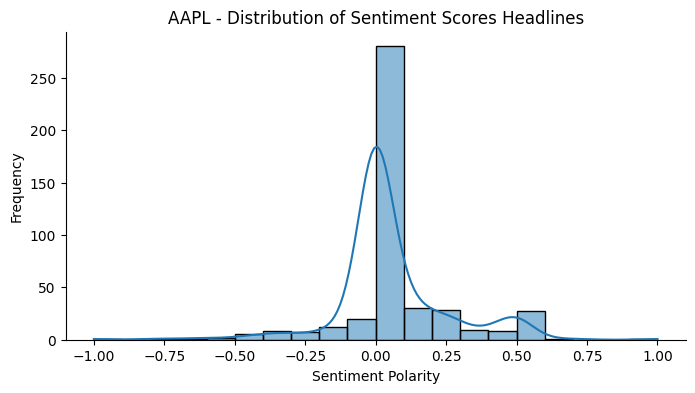

In [15]:
#plot the distribution of sentiment scores and save plot image
plt.figure(figsize=(8, 4))
sns.histplot(AAPL_df['sentiment'], bins=20, kde=True)
plt.title('AAPL - Distribution of Sentiment Scores Headlines')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.gca().spines[['top', 'right']].set_visible(False)


#select plot directory and plot name to save plot image
plot_folder = 'C:/Users/nuhamin/Documents/kifiya/week 1/' \
'Stock-Market-Price-Prediction-with-Sentiment-Analysis/' \
'plot images/news plot'

plot_name = 'AAPL - Distribution of Sentiment Scores Headlines.png'
plot_path = os.path.join(plot_folder, plot_name)

#create the directory if it doesn't exist
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)

#save plot and display message
plt.savefig(plot_path)
print(f'\nPlot is saved.\n')

#display the plot
plt.show()

#close the plot to free up memory
plt.close()

## Text Analysis (Topic Modelling)

In [16]:
#preproces dataframe
  #Converting to lowercase.
  #Removing non-alphanumeric characters (except spaces).
  #Tokenizing the text into words.
  #Removing common English stop words.
  #Lemmatizing words to their base form.

AAPL_text_data = AAPL_df['headline'].dropna().tolist() 

def preprocess_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char.isalnum() or char.isspace()]) #keep alphanumeric and spaces
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

processed_AAPL_text_data = [preprocess_text(text) for text in AAPL_text_data]

In [17]:
#calculate Term Frequency-Inverse Document Frequency (TF-IDF) to identify important terms

#initalise tfidf_vectorizer for upto 1000 single words and two-word phrases 
tfidf_vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2)) #consider unigrams and bigrams

#calculate tfidf_matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(processed_AAPL_text_data)

#get feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

#iterate through each articles to find overall important terms
#terms with highest TF-IDF scores across all documents
print('\nTop TF-IDF terms:\n')

#calculate Average TF-IDF scores
#'.A1' converts the result matrix of means into a 1-dimensional array
average_tfidf = tfidf_matrix.mean(axis=0).A1

#sort and get top terms
sorted_tfidf_indices = average_tfidf.argsort()[::-1]
top_tfidf_terms = [(feature_names[i], average_tfidf[i]) for i in sorted_tfidf_indices[:20]] #top 20
for term, score in top_tfidf_terms:
    print(f'{term}: {score:.4f}')


Top TF-IDF terms:

apple: 0.0585
stock: 0.0245
target: 0.0219
price: 0.0214
price target: 0.0207
say: 0.0206
coronavirus: 0.0197
share: 0.0192
market: 0.0181
iphone: 0.0178
earnings: 0.0176
report: 0.0158
store: 0.0152
company: 0.0145
lower: 0.0141
covid19: 0.0140
china: 0.0133
maintains: 0.0133
buy: 0.0126
trading: 0.0122


In [18]:
#topic Modeling with LDA
num_topics = 10
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(tfidf_matrix)

print(f'\nTopics discovered by LDA ({num_topics} topics):')
for index, topic in enumerate(lda.components_):
    print(f'Topic #{index + 1}:')
    top_words = [feature_names[i] for i in topic.argsort()[-10:]] #get top 10 words for each topic
    print(', '.join(top_words))


Topics discovered by LDA (10 topics):
Topic #1:
option, say, model, target 320, reiterates buy, reiterates, payment, 320, apple, coronavirus
Topic #2:
apple lower, apple raise, raise, buy apple, buy, lower, maintains, price, price target, target
Topic #3:
pick pan, barrons pick, maintains overweight, overweight apple, apple, overweight, morgan stanley, stanley, pick, morgan
Topic #4:
5g, production, 10, biggest price, target change, 10 biggest, apple, biggest, change, iphone
Topic #5:
yesterday, biggest, mover yesterday, coronavirus, foxconn, apple google, biggest mover, mover, google, apple
Topic #6:
stock, sale, ceo, covid19, ceo tim, apple ceo, tim, tim cook, cook, apple
Topic #7:
earnings, midday, midday session, store, etf, apple, stock, session, stock moving, moving
Topic #8:
apple share, say, microsoft, show, huawei, china, global, industry, share, apple
Topic #9:
take, start, bull, cfo, apple cfo, bear, bear week, bull bear, apple, week
Topic #10:
phone, big, apple reopen, app

In [19]:
#named Entity Recognition with spaCy
print('\nNamed Entities (using spaCy - for the first 10 articles):\n')
for i, text in enumerate(AAPL_text_data[:10]): #process 10 
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    if entities:
        print(f'Article {i + 1}: {entities}')
    else:
        print(f'Article {i + 1}: No named entities found.')


Named Entities (using spaCy - for the first 10 articles):

Article 1: [('FAANGS Strong Again', 'PERSON')]
Article 2: [('10', 'CARDINAL'), ('Wednesday', 'DATE')]
Article 3: [("Benzinga Pro's", 'PERSON'), ('5', 'CARDINAL'), ('Jun. 10, 2020:', 'DATE'), ('BAC', 'ORG'), ('NIO', 'ORG'), ('GLW', 'ORG')]
Article 4: [('Deutsche Bank Maintains Buy', 'ORG'), ('Apple', 'ORG'), ('350', 'MONEY')]
Article 5: [('US', 'GPE'), ('Canada', 'GPE')]
Article 6: [('Big Tech Reaches New Record Heights', 'ORG')]
Article 7: [("Apple's Stock Is Trading Higher", 'ORG'), ('Today', 'DATE')]
Article 8: [('Apple', 'ORG')]
Article 9: [('Apple', 'ORG'), ('12', 'CARDINAL'), ('July', 'DATE')]
Article 10: [('9.5%', 'PERCENT'), ('Citron', 'ORG'), ('Andrew Left', 'PERSON'), ('FOX Business', 'ORG'), ('Apple', 'ORG'), ('Amazon', 'ORG')]


## Time Series Analysis


Plot is saved.



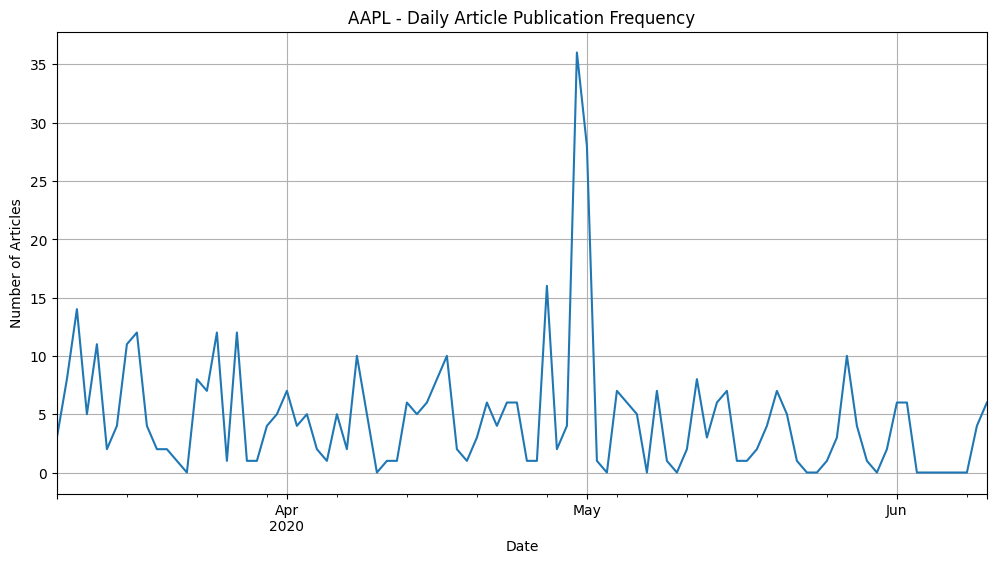

In [20]:
#plot and save the daily publication frequency

#resample to daily frequency and count publications
daily_publications = AAPL_df.resample('D', on='date').size()

#plot
plt.figure(figsize=(12, 6))
daily_publications.plot()
plt.title('AAPL - Daily Article Publication Frequency')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.grid()


#select plot directory and plot name to save plot image
plot_folder = 'C:/Users/nuhamin/Documents/kifiya/week 1/' \
'Stock-Market-Price-Prediction-with-Sentiment-Analysis/' \
'plot images/news plot'

plot_name = 'AAPL - Daily Article Publication Frequency.png'
plot_path = os.path.join(plot_folder, plot_name)

#create the directory if it doesn't exist
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)

#save plot and display message
plt.savefig(plot_path)
print(f'\nPlot is saved.\n')

#display the plot
plt.show()

#close the plot to free up memory
plt.close()


Number of articles published at 00:00 is 432


Plot is saved.



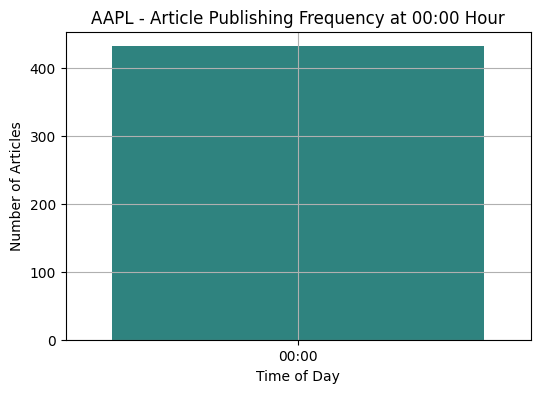

In [21]:
#plot and save the hourly publication frequency for 00:00 hour

#extract the hour from the datetime column
AAPL_df['publish_hour'] = pd.to_datetime(AAPL_df['date']).dt.hour

#filter data for 00:00
zero_hour_data = AAPL_df[AAPL_df['publish_hour'] == 0]

#calculate and print the count of articles published at 00:00
zero_hour_count = len(zero_hour_data)
print(f'\nNumber of articles published at 00:00 is {zero_hour_count}\n')

#plot for 00:00
#Create a small DataFrame 
plot_data = pd.DataFrame({'hour': ['00:00'], 'count': [zero_hour_count]})

plt.figure(figsize=(6, 4))
sns.barplot(x='hour', y='count', data=plot_data, hue='hour', palette='viridis', legend=False)
plt.title('AAPL - Article Publishing Frequency at 00:00 Hour')
plt.xlabel('Time of Day')
plt.ylabel('Number of Articles')
plt.grid()


#select plot directory and plot name to save plot image
plot_folder = 'C:/Users/nuhamin/Documents/kifiya/week 1/' \
'Stock-Market-Price-Prediction-with-Sentiment-Analysis/' \
'plot images/news plot'

plot_name = 'AAPL - Article Publishing Frequency at 00 00 Hour.png'
plot_path = os.path.join(plot_folder, plot_name)

#create the directory if it doesn't exist
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)

#save plot and display message
plt.savefig(plot_path)
print(f'\nPlot is saved.\n')

#display the plot
plt.show()

#close the plot to free up memory
plt.close()


Plot is saved.



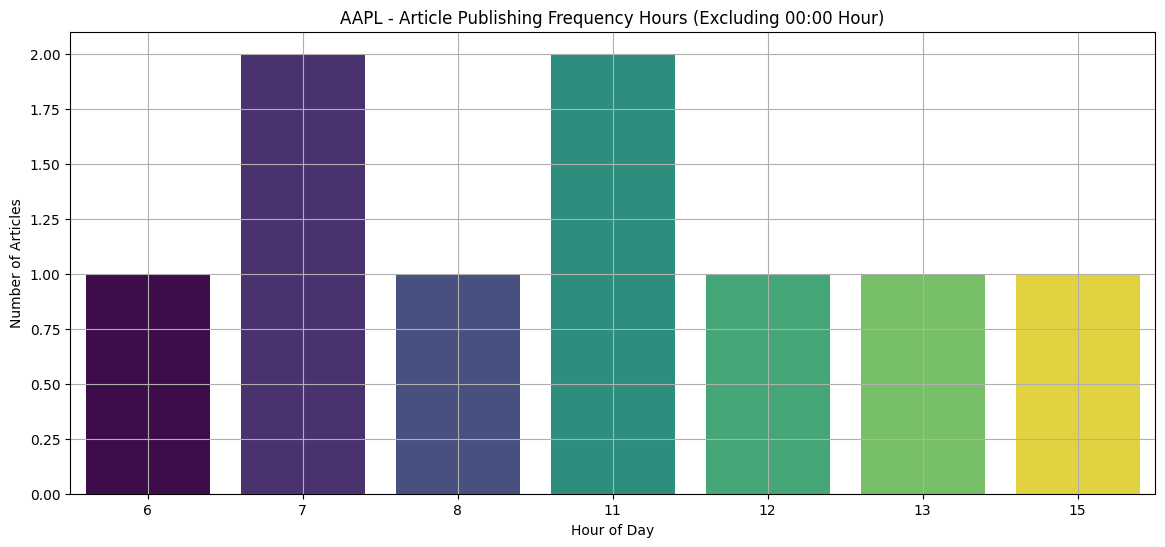

In [22]:
#plot and save the hourly publication frequency for hour other than 00:00 

#filter data for all other times
other_hours_data = AAPL_df[AAPL_df['publish_hour'] != 0]

#plot for 00:00
#Count articles per hour for other times
hourly_counts = other_hours_data['publish_hour'].value_counts().sort_index()

#plot
plt.figure(figsize=(14, 6))
sns.barplot(x=hourly_counts.index, y=hourly_counts.values, 
            hue=hourly_counts.index, palette='viridis', legend=False)
plt.title('AAPL - Article Publishing Frequency Hours (Excluding 00:00 Hour)')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Articles')
plt.xticks()
plt.grid() 


#select plot directory and plot name to save plot image
plot_folder = 'C:/Users/nuhamin/Documents/kifiya/week 1/' \
'Stock-Market-Price-Prediction-with-Sentiment-Analysis/' \
'plot images/news plot'

plot_name = 'AAPL - Article Publishing Frequency Hours (Excluding 00 00 Hour).png'
plot_path = os.path.join(plot_folder, plot_name)

#create the directory if it doesn't exist
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)

#save plot and display message
plt.savefig(plot_path)
print(f'\nPlot is saved.\n')

#display the plot
plt.show()

#close the plot to free up memory
plt.close()

## Publisher Analysis

In [23]:
#sentiment in the type of news specific publishers report

#analyse sentiment by publisher
sentiment_by_publisher = AAPL_df.groupby('publisher')['sentiment'].mean()
print('\nAverage sentiment by publisher:\n')
print(sentiment_by_publisher)


Average sentiment by publisher:

publisher
Benzinga Insights        0.000000
Benzinga Newsdesk        0.064949
Benzinga Staff           0.500000
Benzinga_Newsdesk        0.007889
Charles Gross            0.056182
Craig Jones              0.100000
ETF Professor           -0.050000
Elizabeth Balboa         0.047222
FreightWaves             0.266667
Henry Khederian          0.000000
Howie Bick               0.000000
IAM Newswire             0.068233
JJ Kinahan              -0.019779
Jason Shubnell           0.000000
Javier Hasse             0.136364
Jayson Derrick           0.010179
Lisa Levin               0.021875
Luis Aureliano          -0.050000
Luke J Jacobi            0.062500
Neer Varshney            0.028329
Nelson Hem               0.457341
Othanas Economopoulos    0.000000
Priya Nigam              0.100000
Renato Capelj           -0.028571
Shanthi Rexaline         0.170192
Shivdeep Dhaliwal        0.023542
Spencer Israel           0.139394
TD Ameritrade            0.050000
TD A

In [24]:
#identify unique domains to check if  publisher is email adress instead of name
#extract the domain from each email address in the 'publisher' column
AAPL_df['domain'] = AAPL_df['publisher'].apply(lambda x: x.split('@')[-1] if '@' in x else 'Not an email')

#count the occurrences of each unique domain
domain_counts = AAPL_df['domain'].value_counts()

#display the domains with the highest counts (excluding 'Not an email' if it exists)
print('\nDomains with the most contributions:\n')
print(domain_counts[domain_counts.index != 'Not an email'].head())


Domains with the most contributions:

domain
benzinga.com    4
Name: count, dtype: int64


# **AMZN** #

In [25]:
#assign df to a variable and display head
AMZN_df = stock_dfs['AMZN']
AMZN_df.head()

,date,headline,publisher,stock,url,sentiment
0,2020-06-10 13:18:50-04:00,How Cannabis Company Cannaphyll Is Marketing O...,Jaycee Tenn,AMZN,https://www.benzinga.com/markets/cannabis/20/0...,0.000000
1,2020-06-10 11:33:26-04:00,Tech Stocks And FAANGS Strong Again To Start D...,JJ Kinahan,AMZN,https://www.benzinga.com/government/20/06/1622...,0.433333
2,2020-06-10 07:53:47-04:00,"Benzinga Pro's Top 5 Stocks To Watch For Wed.,...",Benzinga Newsdesk,AMZN,https://www.benzinga.com/short-sellers/20/06/1...,0.500000
3,2020-06-10 07:20:03-04:00,"Hearing Vertical Group Out Positive On Amazon,...",Benzinga Newsdesk,AMZN,https://www.benzinga.com/analyst-ratings/analy...,0.227273
4,2020-06-10 00:52:01-04:00,Big Tech Reaches New Record Heights At The Sto...,Neer Varshney,AMZN,https://www.benzinga.com/news/20/06/16218615/b...,0.068182


## Descriptive Statistics

In [26]:
#display descriptive statistics for the 'headline' column
print("Descriptive statistics for 'headline' column:")
print(AMZN_df['headline'].describe())

#get the number of unique headlines
print("\nNumber of unique headlines:")
print(AMZN_df['headline'].nunique())

#calculate headline length
AMZN_df['headline_length'] = AMZN_df['headline'].apply(len)
print("\nBasic statistics for 'headline_length' column:")
print(AMZN_df['headline_length'].describe())

#display the most frequent headlines
print("\nMost frequent headlines:")
print(AMZN_df['headline'].value_counts().head())

Descriptive statistics for 'headline' column:
count                                   278
unique                                  275
top       Morning Market Stats in 5 Minutes
freq                                      3
Name: headline, dtype: object

Number of unique headlines:
275

Basic statistics for 'headline_length' column:
count    278.000000
mean      81.255396
std       38.166785
min       29.000000
25%       58.000000
50%       75.000000
75%       91.000000
max      254.000000
Name: headline_length, dtype: float64

Most frequent headlines:
headline
Morning Market Stats in 5 Minutes                                                                                                                     3
UPDATE: Judiciary Panel Says Will Investigate Related To Amazon 'Possibly Criminally False, Perjurious' Statements By Co. About Business Practices    2
Locked Down, Demand Up: Amazon Shines As Virus Economy Plays To Its Strengths                                                     

In [27]:
#count the number of articles per publisher 
print('Number of articles per publisher:\n')
print(AMZN_df['publisher'].value_counts())

Number of articles per publisher:

publisher
Benzinga Newsdesk          67
Neer Varshney              21
FreightWaves               20
JJ Kinahan                 19
Lisa Levin                 17
Shivdeep Dhaliwal          14
Vick Meyer                 13
IAM Newswire               13
Charles Gross              10
ETF Professor              10
Benzinga_Newsdesk           8
Jayson Derrick              8
Wayne Duggan                8
Crystal Mills               7
Benzinga Insights           6
Nelson Hem                  5
Tanzeel Akhtar              4
Renato Capelj               4
Joel Elconin                4
Priya Nigam                 2
Craig Jones                 2
Elizabeth Balboa            2
Jaycee Tenn                 1
Luke J Jacobi               1
Dylan Wittenberg            1
Rich Worthington            1
Eric Mancini                1
AARP                        1
TD Ameritrade               1
The Fresh Toast             1
Direxion                    1
Shanthi Rexaline         


Publication trends by day of the week:
publication_day
Friday       64
Wednesday    58
Tuesday      54
Thursday     49
Monday       40
Saturday      7
Sunday        6
Name: count, dtype: int64

Plot is saved.



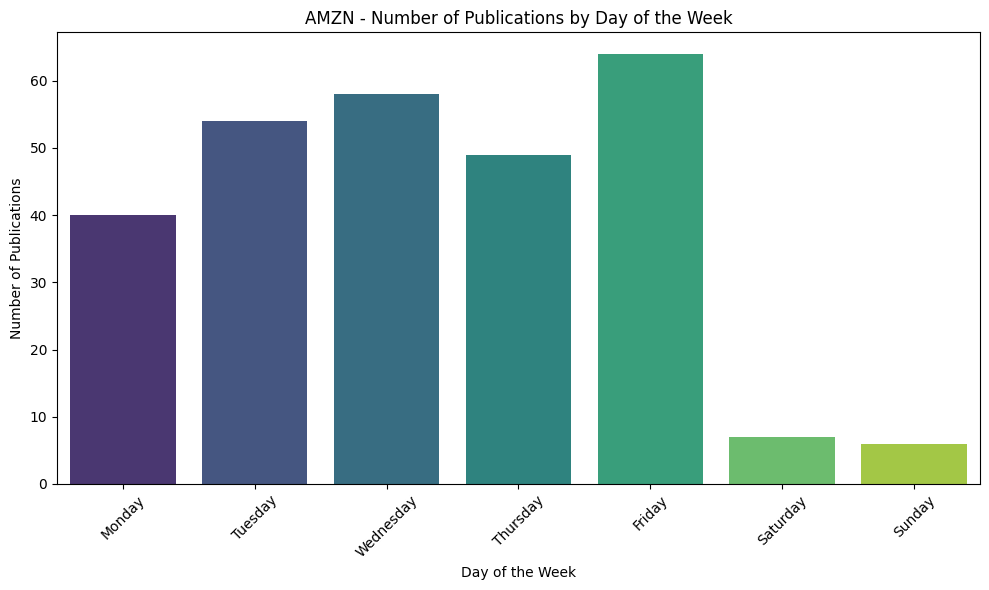

In [28]:
#analyse publication dates
AMZN_df['publication_day'] = AMZN_df['date'].dt.day_name()
print("\nPublication trends by day of the week:")
print(AMZN_df['publication_day'].value_counts())

#plot publication dates and save plot image 
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
publication_day_counts = AMZN_df['publication_day'].value_counts().reindex(day_order)

plt.figure(figsize=(10, 6))
sns.barplot(x=publication_day_counts.index, y=publication_day_counts.values, 
            hue=publication_day_counts.index, palette='viridis', legend=False)
plt.title('AMZN - Number of Publications by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Publications')
plt.xticks(rotation=45)
plt.tight_layout()

#select plot directory and plot name to save plot
plot_folder = 'C:/Users/nuhamin/Documents/kifiya/week 1/' \
'Stock-Market-Price-Prediction-with-Sentiment-Analysis/' \
'plot images/news plot'

plot_name = 'AMZN - Number of Publications by Day of the Week.png'
plot_path = os.path.join(plot_folder, plot_name)

#create the directory if it doesn't exist
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)

#save plot and display message
plt.savefig(plot_path)
print(f'\nPlot is saved.\n')

#display the plot
plt.show()

#close the plot to free up memory
plt.close()

## Sentiment Analysis

In [29]:

#calculate distribution of sentiment scores
print('Sentiment distribution:')
print(AMZN_df['sentiment'].describe())

#analyse the sentiment of the most positive and negative headlines
#most positive headlines
most_positive_headlines = AMZN_df.nlargest(5, 'sentiment')
print("\nMost Positive Headlines:")
print(most_positive_headlines[['headline', 'sentiment']])

#most negative headlines
most_negative_headlines = AMZN_df.nsmallest(5, 'sentiment')
print("\nMost Negative Headlines:")
print(most_negative_headlines[['headline', 'sentiment']])

Sentiment distribution:
count    278.000000
mean       0.040260
std        0.186108
min       -0.625000
25%        0.000000
50%        0.000000
75%        0.034470
max        0.800000
Name: sentiment, dtype: float64

Most Positive Headlines:
                                              headline  sentiment
230  'Jeff Bezos and Elon Musk win contracts for sp...   0.800000
99   Quick Retreat: Impressive Thursday Turnaround ...   0.544444
2    Benzinga Pro's Top 5 Stocks To Watch For Wed.,...   0.500000
13   Pepper Spray, Books On Racism, 'I Can't Breath...   0.500000
24   Apple CEO Writes To Employees About George Flo...   0.500000

Most Negative Headlines:
                                              headline  sentiment
46   Trump Gets Mad Over Fact Check Warning On Twit...  -0.625000
194  Disappointment From Amazon, Apple Weighs On Ma...  -0.600000
56   The Secret to Tech's Resilience to COVID-19- I...  -0.400000
69   Amazon Issues Press Release Highlighting 'Cruc...  -0.400000
18   G


Plot is saved.



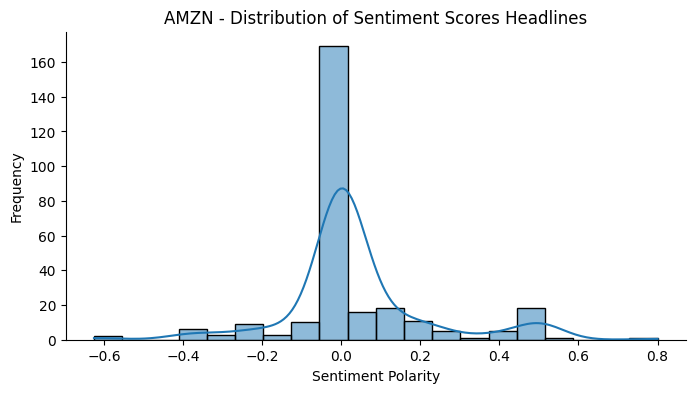

In [30]:
#plot the distribution of sentiment scores
plt.figure(figsize=(8, 4))
sns.histplot(AMZN_df['sentiment'], bins=20, kde=True)
plt.title('AMZN - Distribution of Sentiment Scores Headlines')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.gca().spines[['top', 'right']].set_visible(False)


#select plot directory and plot name to save plot image
plot_folder = 'C:/Users/nuhamin/Documents/kifiya/week 1/' \
'Stock-Market-Price-Prediction-with-Sentiment-Analysis/' \
'plot images/news plot'

plot_name = 'AMZN - Distribution of Sentiment Scores Headlines.png'
plot_path = os.path.join(plot_folder, plot_name)

#create the directory if it doesn't exist
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)

#save plot and display message
plt.savefig(plot_path)
print(f'\nPlot is saved.\n')

#display the plot
plt.show()

#close the plot to free up memory
plt.close()

## Text Analysis (Topic Modelling)

In [31]:
#preproces dataframe
  #Converting to lowercase.
  #Removing non-alphanumeric characters (except spaces).
  #Tokenizing the text into words.
  #Removing common English stop words.
  #Lemmatizing words to their base form.

AMZN_text_data = AMZN_df['headline'].dropna().tolist() 

def preprocess_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char.isalnum() or char.isspace()]) #keep alphanumeric and spaces
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

processed_AMZN_text_data = [preprocess_text(text) for text in AMZN_text_data]

In [32]:
#calculate Term Frequency-Inverse Document Frequency (TF-IDF) to identify important terms

#initalise tfidf_vectorizer for upto 1000 single words and two-word phrases 
tfidf_vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2)) #consider unigrams and bigrams

#calculate tfidf_matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(processed_AMZN_text_data)

#get feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

#iterate through each articles to find overall important terms
#terms with highest TF-IDF scores across all documents
print('\nTop TF-IDF terms:\n')

#calculate Average TF-IDF scores
#'.A1' converts the result matrix of means into a 1-dimensional array
average_tfidf = tfidf_matrix.mean(axis=0).A1

#sort and get top terms
sorted_tfidf_indices = average_tfidf.argsort()[::-1]
top_tfidf_terms = [(feature_names[i], average_tfidf[i]) for i in sorted_tfidf_indices[:20]] #top 20
for term, score in top_tfidf_terms:
    print(f'{term}: {score:.4f}')


Top TF-IDF terms:

amazon: 0.0557
stock: 0.0295
amazoncom: 0.0207
target: 0.0207
earnings: 0.0198
market: 0.0197
price: 0.0193
raise: 0.0183
buy: 0.0179
price target: 0.0179
etf: 0.0168
maintains: 0.0167
say: 0.0159
raise price: 0.0158
amazoncom raise: 0.0158
may: 0.0156
new: 0.0137
share: 0.0137
report: 0.0132
pandemic: 0.0125


In [33]:
#topic Modeling with LDA
num_topics = 10
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(tfidf_matrix)

print(f'\nTopics discovered by LDA ({num_topics} topics):')
for index, topic in enumerate(lda.components_):
    print(f'Topic #{index + 1}:')
    top_words = [feature_names[i] for i in topic.argsort()[-10:]] #get top 10 words for each topic
    print(', '.join(top_words))


Topics discovered by LDA (10 topics):
Topic #1:
stock watch, watch, pandemic, watch may, may, security, medium, social medium, social, stock
Topic #2:
chain, supply, supply chain, talk, financial, deal, zoox, said, amazon said, amazon
Topic #3:
30 2020, april 30, overweight amazoncom, facebook, see, turn, etf, earnings, amazon, share
Topic #4:
stats, morning market, stats minute, market stats, price target, raise, maintains, amazon, target, market
Topic #5:
day september, prime day, record, high, hit, web, new, service, stock, amazon
Topic #6:
buy amazoncom, target, maintains, price target, raise, amazoncom raise, raise price, price, buy, amazoncom
Topic #7:
stock moving, moving, stock day, prep stock, prep, premarket prep, report, day, premarket, stock
Topic #8:
market stock, peek market, stock future, peek, walmart, market, earnings, ahead, week, amazon
Topic #9:
winner, demand amazon, stock, network, pick, barrons, pan, barrons pick, pick pan, amazon
Topic #10:
twitter, today, bezo

In [34]:
#named Entity Recognition with spaCy
print('\nNamed Entities (using spaCy - for the first 10 articles):\n')
for i, text in enumerate(AMZN_text_data[:10]): #process 10 
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    if entities:
        print(f'Article {i + 1}: {entities}')
    else:
        print(f'Article {i + 1}: No named entities found.')


Named Entities (using spaCy - for the first 10 articles):

Article 1: [('Google', 'ORG'), ('Amazon', 'ORG')]
Article 2: [('FAANGS Strong Again', 'PERSON')]
Article 3: [("Benzinga Pro's", 'PERSON'), ('5', 'CARDINAL'), ('Jun. 10, 2020:', 'DATE'), ('BAC', 'ORG'), ('NIO', 'ORG'), ('GLW', 'ORG')]
Article 4: [('Hearing Vertical Group Out', 'ORG'), ('Amazon', 'ORG'), ("Saying Co.'s", 'ORG')]
Article 5: [('Big Tech Reaches New Record Heights', 'ORG')]
Article 6: [('Honor African-American', 'NORP')]
Article 7: [('Amazon', 'ORG'), ("every two weeks'", 'DATE'), ('CNBC', 'ORG')]
Article 8: [('BofA Raises Amazon Target', 'PERSON'), ('Sales Upside', 'ORG')]
Article 9: [('Amazon', 'ORG')]
Article 10: [('IRS Alerts Against Criminals Profiteering From Fake Coronavirus Treatments', 'ORG')]


## Time Series Analysis


Plot is saved.



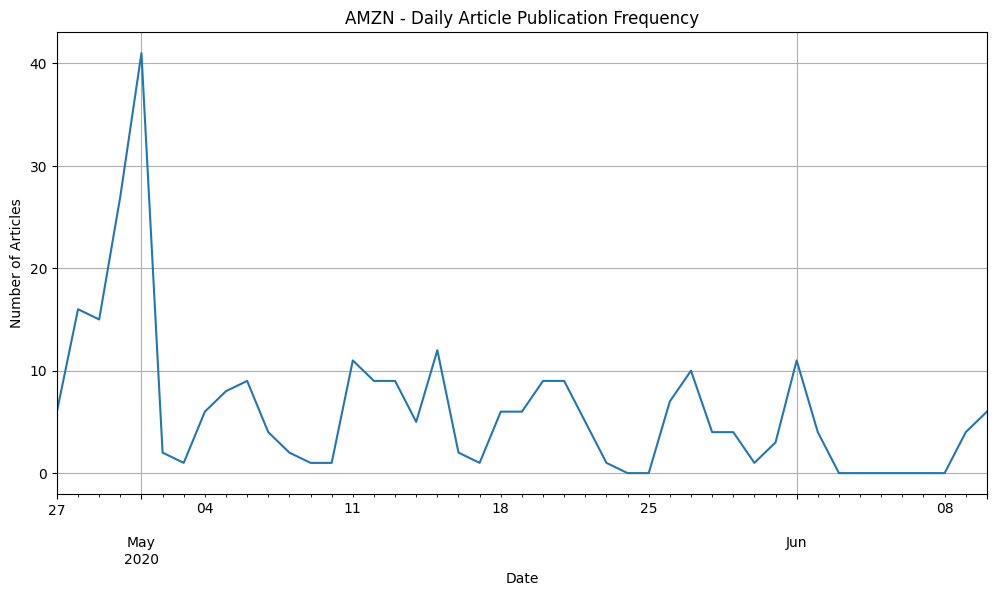

In [35]:
#plot and save the daily publication frequency

#resample to daily frequency and count publications
daily_publications = AMZN_df.resample('D', on='date').size()

#plot
plt.figure(figsize=(12, 6))
daily_publications.plot()
plt.title('AMZN - Daily Article Publication Frequency')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.grid()


#select plot directory and plot name to save plot image
plot_folder = 'C:/Users/nuhamin/Documents/kifiya/week 1/' \
'Stock-Market-Price-Prediction-with-Sentiment-Analysis/' \
'plot images/news plot'

plot_name = 'AMZN - Daily Article Publication Frequency.png'
plot_path = os.path.join(plot_folder, plot_name)

#create the directory if it doesn't exist
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)

#save plot and display message
plt.savefig(plot_path)
print(f'\nPlot is saved.\n')

#display the plot
plt.show()

#close the plot to free up memory
plt.close()


Number of articles published at 00:00 is 270


Plot is saved.



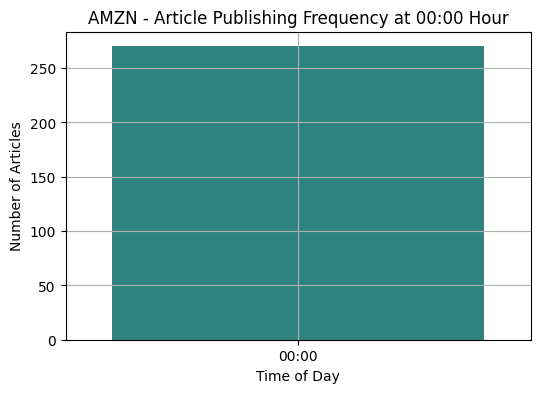

In [36]:
#plot and save the hourly publication frequency for 00:00 hour

#extract the hour from the datetime column
AMZN_df['publish_hour'] = pd.to_datetime(AMZN_df['date']).dt.hour

#filter data for 00:00
zero_hour_data = AMZN_df[AMZN_df['publish_hour'] == 0]

#calculate and print the count of articles published at 00:00
zero_hour_count = len(zero_hour_data)
print(f'\nNumber of articles published at 00:00 is {zero_hour_count}\n')

#plot for 00:00
#Create a small DataFrame 
plot_data = pd.DataFrame({'hour': ['00:00'], 'count': [zero_hour_count]})

plt.figure(figsize=(6, 4))
sns.barplot(x='hour', y='count', data=plot_data, hue='hour', palette='viridis', legend=False)
plt.title('AMZN - Article Publishing Frequency at 00:00 Hour')
plt.xlabel('Time of Day')
plt.ylabel('Number of Articles')
plt.grid()


#select plot directory and plot name to save plot image
plot_folder = 'C:/Users/nuhamin/Documents/kifiya/week 1/' \
'Stock-Market-Price-Prediction-with-Sentiment-Analysis/' \
'plot images/news plot'

plot_name = 'AMZN - Article Publishing Frequency at 00 00 Hour.png'
plot_path = os.path.join(plot_folder, plot_name)

#create the directory if it doesn't exist
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)

#save plot and display message
plt.savefig(plot_path)
print(f'\nPlot is saved.\n')

#display the plot
plt.show()

#close the plot to free up memory
plt.close()


Plot is saved.



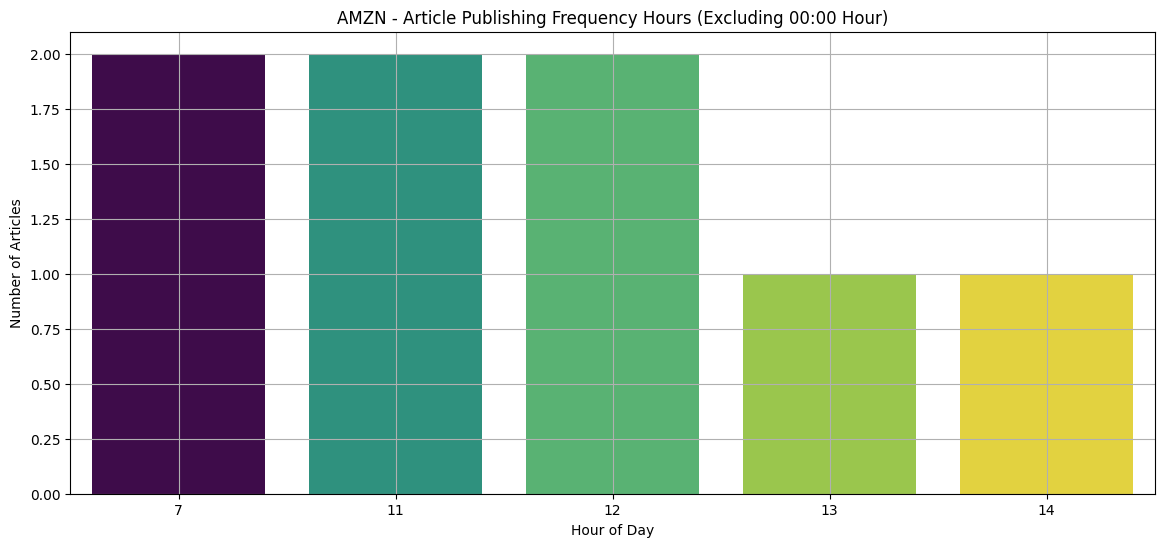

In [37]:
#plot and save the hourly publication frequency for hour other than 00:00 

#filter data for all other times
other_hours_data = AMZN_df[AMZN_df['publish_hour'] != 0]

#plot for 00:00
#Count articles per hour for other times
hourly_counts = other_hours_data['publish_hour'].value_counts().sort_index()

#plot
plt.figure(figsize=(14, 6))
sns.barplot(x=hourly_counts.index, y=hourly_counts.values, 
            hue=hourly_counts.index, palette='viridis', legend=False)
plt.title('AMZN - Article Publishing Frequency Hours (Excluding 00:00 Hour)')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Articles')
plt.xticks()
plt.grid() 


#select plot directory and plot name to save plot image
plot_folder = 'C:/Users/nuhamin/Documents/kifiya/week 1/' \
'Stock-Market-Price-Prediction-with-Sentiment-Analysis/' \
'plot images/news plot'

plot_name = 'AMZN - Article Publishing Frequency Hours (Excluding 00 00 Hour).png'
plot_path = os.path.join(plot_folder, plot_name)

#create the directory if it doesn't exist
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)

#save plot and display message
plt.savefig(plot_path)
print(f'\nPlot is saved.\n')

#display the plot
plt.show()

#close the plot to free up memory
plt.close()

## Publisher Analysis

In [38]:
#sentiment in the type of news specific publishers report

#analyse sentiment by publisher
sentiment_by_publisher = AMZN_df.groupby('publisher')['sentiment'].mean()
print('\nAverage sentiment by publisher:\n')
print(sentiment_by_publisher)


Average sentiment by publisher:

publisher
AARP                       0.017857
Benzinga Insights          0.000000
Benzinga Newsdesk          0.049367
Benzinga_Newsdesk          0.025000
Charles Gross             -0.006364
Craig Jones                0.425000
Crystal Mills              0.023052
Direxion                   0.500000
Dylan Wittenberg           0.000000
ETF Professor             -0.020000
Elizabeth Balboa           0.250000
Eric Mancini               0.100000
FreightWaves               0.005152
IAM Newswire               0.051282
JJ Kinahan                -0.006510
Jaycee Tenn                0.000000
Jayson Derrick            -0.001705
Joel Elconin               0.000000
Khyathi Dalal              0.400000
Lisa Levin                 0.017320
Luke J Jacobi              0.000000
Neer Varshney              0.039899
Nelson Hem                 0.500000
Priya Nigam                0.000000
Renato Capelj              0.034091
Rich Worthington           0.000000
Shanthi Rexaline    

In [39]:
#identify unique domains to check if  publisher is email adress instead of name
#extract the domain from each email address in the 'publisher' column
AMZN_df['domain'] = AMZN_df['publisher'].apply(lambda x: x.split('@')[-1] if '@' in x else 'Not an email')

#count the occurrences of each unique domain
domain_counts = AMZN_df['domain'].value_counts()

#display the domains with the highest counts (excluding 'Not an email' if it exists)
print('\nDomains with the most contributions:\n')
print(domain_counts[domain_counts.index != 'Not an email'].head())


Domains with the most contributions:

domain
benzinga.com    1
Name: count, dtype: int64


# **GOOG** #

In [40]:
#assign df to a variable and display head
GOOG_df = stock_dfs['GOOG']
GOOG_df.head()

,date,headline,publisher,stock,url,sentiment
0,2020-06-10 15:25:13-04:00,"Facebook, Snap Analyst Projects Q2 Revenue Ups...",Shanthi Rexaline,GOOG,https://www.benzinga.com/analyst-ratings/analy...,0.033333
1,2020-06-10 13:18:50-04:00,How Cannabis Company Cannaphyll Is Marketing O...,Jaycee Tenn,GOOG,https://www.benzinga.com/markets/cannabis/20/0...,0.000000
2,2020-06-10 00:28:00-04:00,"Twitter, Square Will Mark Juneteenth As Holida...",Shivdeep Dhaliwal,GOOG,https://www.benzinga.com/news/20/06/16218441/t...,0.000000
3,2020-06-09 14:39:26-04:00,Price Over Earnings Overview: Alphabet,Benzinga Insights,GOOG,https://www.benzinga.com/intraday-update/20/06...,0.000000
4,2020-06-09 03:51:41-04:00,Google Maps To Offer Relevant Local COVID-19 I...,Shivdeep Dhaliwal,GOOG,https://www.benzinga.com/news/20/06/16208274/g...,0.133333


## Descriptive Statistics

In [41]:
#display descriptive statistics for the 'headline' column
print("Descriptive statistics for 'headline' column:")
print(GOOG_df['headline'].describe())

#get the number of unique headlines
print("\nNumber of unique headlines:")
print(GOOG_df['headline'].nunique())

#calculate headline length
GOOG_df['headline_length'] = GOOG_df['headline'].apply(len)
print("\nBasic statistics for 'headline_length' column:")
print(GOOG_df['headline_length'].describe())

#display the most frequent headlines
print("\nMost frequent headlines:")
print(GOOG_df['headline'].value_counts().head())

Descriptive statistics for 'headline' column:
count                                         1199
unique                                        1183
top       Stocks That Hit 52-Week Highs On Tuesday
freq                                             4
Name: headline, dtype: object

Number of unique headlines:
1183

Basic statistics for 'headline_length' column:
count    1199.000000
mean       86.687239
std        46.697582
min        18.000000
25%        57.000000
50%        75.000000
75%        95.000000
max       315.000000
Name: headline_length, dtype: float64

Most frequent headlines:
headline
Stocks That Hit 52-Week Highs On Tuesday                                                              4
Stocks That Hit 52-Week Highs On Friday                                                               4
Stocks That Hit 52-Week Highs On Thursday                                                             3
Alphabet shares are trading lower after the company reported worse-than-expected Q4 s

In [42]:
#count the number of articles per publisher 
print('Number of articles per publisher:\n')
print(GOOG_df['publisher'].value_counts())

Number of articles per publisher:

publisher
Benzinga Newsdesk    408
Neer Varshney         68
JJ Kinahan            68
Wayne Duggan          64
Benzinga_Newsdesk     62
                    ... 
Hal Lindon             1
Dustin Blitchok        1
Nick Esquer            1
Scott Connor           1
Spencer White          1
Name: count, Length: 73, dtype: int64



Publication trends by day of the week:
publication_day
Tuesday      287
Monday       252
Wednesday    235
Thursday     212
Friday       185
Sunday        16
Saturday      12
Name: count, dtype: int64

Plot is saved.



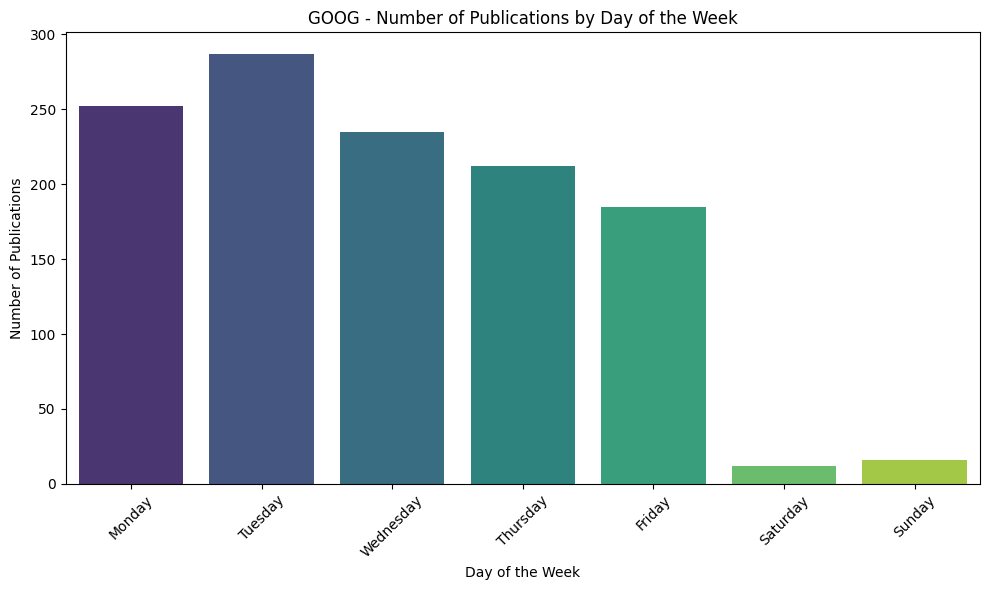

In [43]:
#analyse publication dates
GOOG_df['publication_day'] = GOOG_df['date'].dt.day_name()
print("\nPublication trends by day of the week:")
print(GOOG_df['publication_day'].value_counts())

#plot publication dates and save plot image 
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
publication_day_counts = GOOG_df['publication_day'].value_counts().reindex(day_order)

plt.figure(figsize=(10, 6))
sns.barplot(x=publication_day_counts.index, y=publication_day_counts.values, 
            hue=publication_day_counts.index, palette='viridis', legend=False)
plt.title('GOOG - Number of Publications by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Publications')
plt.xticks(rotation=45)
plt.tight_layout()

#select plot directory and plot name to save plot
plot_folder = 'C:/Users/nuhamin/Documents/kifiya/week 1/' \
'Stock-Market-Price-Prediction-with-Sentiment-Analysis/' \
'plot images/news plot'

plot_name = 'GOOG - Number of Publications by Day of the Week.png'
plot_path = os.path.join(plot_folder, plot_name)

#create the directory if it doesn't exist
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)

#save plot and display message
plt.savefig(plot_path)
print(f'\nPlot is saved.\n')

#display the plot
plt.show()

#close the plot to free up memory
plt.close()

## Sentiment Analysis

In [44]:

#calculate distribution of sentiment scores
print('Sentiment distribution:')
print(GOOG_df['sentiment'].describe())

#analyse the sentiment of the most positive and negative headlines
#most positive headlines
most_positive_headlines = GOOG_df.nlargest(5, 'sentiment')
print("\nMost Positive Headlines:")
print(most_positive_headlines[['headline', 'sentiment']])

#most negative headlines
most_negative_headlines = GOOG_df.nsmallest(5, 'sentiment')
print("\nMost Negative Headlines:")
print(most_negative_headlines[['headline', 'sentiment']])

Sentiment distribution:
count    1199.000000
mean        0.047689
std         0.175878
min        -0.700000
25%         0.000000
50%         0.000000
75%         0.068182
max         1.000000
Name: sentiment, dtype: float64

Most Positive Headlines:
                                               headline  sentiment
179   Ty Cobb: The Greatest Pro Athlete Investor Of ...        1.0
1185  This Leveraged ETF Rapidly Became One Of Novem...        1.0
92    Analysts Applaud Alphabet Earnings: 'An Incred...        0.9
329   'Google Could Acquire Tesla For $1,500 Per Sha...        0.8
567   3 Reasons Fitbit Could Be An Attractive M&A Ta...        0.8

Most Negative Headlines:
                                              headline  sentiment
133  Crude Oil Bounce Gives Energy Stock A Lift As ...      -0.70
993  Meetings Are Expensive, But Artificial Intelli...      -0.55
110  YouTube Extends Fact Checking To The US To Com...      -0.50
162  YouTube Exec Talks Entertainment, Combatting C...    


Plot is saved.



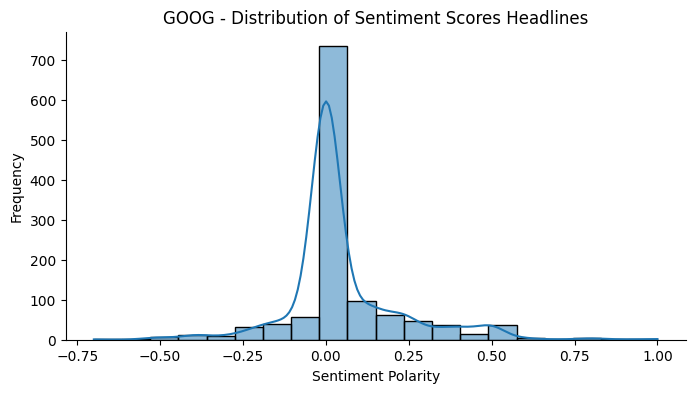

In [45]:
#plot the distribution of sentiment scores
plt.figure(figsize=(8, 4))
sns.histplot(GOOG_df['sentiment'], bins=20, kde=True)
plt.title('GOOG - Distribution of Sentiment Scores Headlines')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.gca().spines[['top', 'right']].set_visible(False)


#select plot directory and plot name to save plot image
plot_folder = 'C:/Users/nuhamin/Documents/kifiya/week 1/' \
'Stock-Market-Price-Prediction-with-Sentiment-Analysis/' \
'plot images/news plot'

plot_name = 'GOOG - Distribution of Sentiment Scores Headlines.png'
plot_path = os.path.join(plot_folder, plot_name)

#create the directory if it doesn't exist
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)

#save plot and display message
plt.savefig(plot_path)
print(f'\nPlot is saved.\n')

#display the plot
plt.show()

#close the plot to free up memory
plt.close()

## Text Analysis (Topic Modelling)

In [46]:
#preproces dataframe
  #Converting to lowercase.
  #Removing non-alphanumeric characters (except spaces).
  #Tokenizing the text into words.
  #Removing common English stop words.
  #Lemmatizing words to their base form.

GOOG_text_data = GOOG_df['headline'].dropna().tolist() 

def preprocess_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char.isalnum() or char.isspace()]) #keep alphanumeric and spaces
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

processed_GOOG_text_data = [preprocess_text(text) for text in GOOG_text_data]

In [47]:
#calculate Term Frequency-Inverse Document Frequency (TF-IDF) to identify important terms

#initalise tfidf_vectorizer for upto 1000 single words and two-word phrases 
tfidf_vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2)) #consider unigrams and bigrams

#calculate tfidf_matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(processed_GOOG_text_data)

#get feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

#iterate through each articles to find overall important terms
#terms with highest TF-IDF scores across all documents
print('\nTop TF-IDF terms:\n')

#calculate Average TF-IDF scores
#'.A1' converts the result matrix of means into a 1-dimensional array
average_tfidf = tfidf_matrix.mean(axis=0).A1

#sort and get top terms
sorted_tfidf_indices = average_tfidf.argsort()[::-1]
top_tfidf_terms = [(feature_names[i], average_tfidf[i]) for i in sorted_tfidf_indices[:20]] #top 20
for term, score in top_tfidf_terms:
    print(f'{term}: {score:.4f}')


Top TF-IDF terms:

google: 0.0553
alphabet: 0.0286
stock: 0.0234
say: 0.0227
earnings: 0.0189
share: 0.0169
cloud: 0.0164
youtube: 0.0154
apple: 0.0150
company: 0.0149
market: 0.0149
coronavirus: 0.0134
tech: 0.0132
report: 0.0130
new: 0.0121
facebook: 0.0119
amazon: 0.0111
target: 0.0109
data: 0.0102
etf: 0.0099


In [48]:
#topic Modeling with LDA
num_topics = 10
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(tfidf_matrix)

print(f'\nTopics discovered by LDA ({num_topics} topics):')
for index, topic in enumerate(lda.components_):
    print(f'Topic #{index + 1}:')
    top_words = [feature_names[i] for i in topic.argsort()[-10:]] #get top 10 words for each topic
    print(', '.join(top_words))


Topics discovered by LDA (10 topics):
Topic #1:
result, step, intel, share, solution, q1, google, alphabet, google cloud, cloud
Topic #2:
blog, market, user, say, video, announces, youtube, stadium, game, google
Topic #3:
session, raise, buy, stock, price, stock moving, moving, maintains, target, alphabet
Topic #4:
co, search, hearing, facebook, youtube, microsoft, business, ad, say, google
Topic #5:
event, pixel, big tech, big, trump, social medium, social, medium, tech, google
Topic #6:
faang, stock watch, communication service, service, earnings, 2019, youtube, watch, future, stock
Topic #7:
think, say, home, ai, cnbc, case, competition, data, employee, google
Topic #8:
earnings, ceo, estimate, may, biggest, q4, google, beat, alphabet, time
Topic #9:
high, stock, hit 52week, 52week, stock hit, take, antitrust, hit, probe, google
Topic #10:
share several, earnings, lower, several, company, stock, coronavirus, market, trading, share


In [49]:
#named Entity Recognition with spaCy
print('\nNamed Entities (using spaCy - for the first 10 articles):\n')
for i, text in enumerate(GOOG_text_data[:10]): #process 10 
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    if entities:
        print(f'Article {i + 1}: {entities}')
    else:
        print(f'Article {i + 1}: No named entities found.')


Named Entities (using spaCy - for the first 10 articles):

Article 1: No named entities found.
Article 2: [('Google', 'ORG'), ('Amazon', 'ORG')]
Article 3: [('Honor African-American', 'NORP')]
Article 4: No named entities found.
Article 5: No named entities found.
Article 6: [('This Week', 'DATE'), ('U.S.', 'GPE'), ('New Google Maps Features Alert', 'ORG')]
Article 7: [('CNBC', 'ORG'), ('Google', 'ORG'), ('Ad Tech Business', 'ORG')]
Article 8: [('Congress', 'ORG')]
Article 9: [('George Floyd', 'PERSON')]
Article 10: [('Chinese', 'NORP'), ('Joe Biden', 'PERSON')]


## Time Series Analysis


Plot is saved.



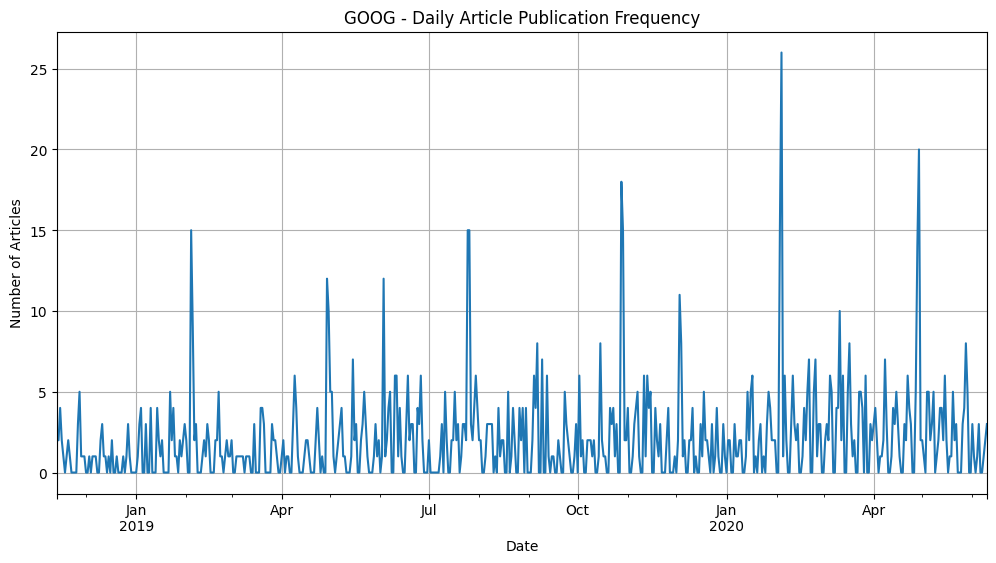

In [50]:
#plot and save the daily publication frequency

#resample to daily frequency and count publications
daily_publications = GOOG_df.resample('D', on='date').size()

#plot
plt.figure(figsize=(12, 6))
daily_publications.plot()
plt.title('GOOG - Daily Article Publication Frequency')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.grid()


#select plot directory and plot name to save plot image
plot_folder = 'C:/Users/nuhamin/Documents/kifiya/week 1/' \
'Stock-Market-Price-Prediction-with-Sentiment-Analysis/' \
'plot images/news plot'

plot_name = 'GOOG - Daily Article Publication Frequency.png'
plot_path = os.path.join(plot_folder, plot_name)

#create the directory if it doesn't exist
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)

#save plot and display message
plt.savefig(plot_path)
print(f'\nPlot is saved.\n')

#display the plot
plt.show()

#close the plot to free up memory
plt.close()


Number of articles published at 00:00 is 1190


Plot is saved.



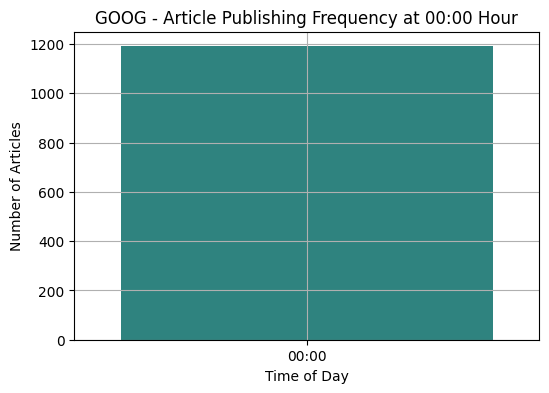

In [51]:
#plot and save the hourly publication frequency for 00:00 hour

#extract the hour from the datetime column
GOOG_df['publish_hour'] = pd.to_datetime(GOOG_df['date']).dt.hour

#filter data for 00:00
zero_hour_data = GOOG_df[GOOG_df['publish_hour'] == 0]

#calculate and print the count of articles published at 00:00
zero_hour_count = len(zero_hour_data)
print(f'\nNumber of articles published at 00:00 is {zero_hour_count}\n')

#plot for 00:00
#Create a small DataFrame 
plot_data = pd.DataFrame({'hour': ['00:00'], 'count': [zero_hour_count]})

plt.figure(figsize=(6, 4))
sns.barplot(x='hour', y='count', data=plot_data, hue='hour', palette='viridis', legend=False)
plt.title('GOOG - Article Publishing Frequency at 00:00 Hour')
plt.xlabel('Time of Day')
plt.ylabel('Number of Articles')
plt.grid()


#select plot directory and plot name to save plot image
plot_folder = 'C:/Users/nuhamin/Documents/kifiya/week 1/' \
'Stock-Market-Price-Prediction-with-Sentiment-Analysis/' \
'plot images/news plot'

plot_name = 'GOOG - Article Publishing Frequency at 00 00 Hour.png'
plot_path = os.path.join(plot_folder, plot_name)

#create the directory if it doesn't exist
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)

#save plot and display message
plt.savefig(plot_path)
print(f'\nPlot is saved.\n')

#display the plot
plt.show()

#close the plot to free up memory
plt.close()


Plot is saved.



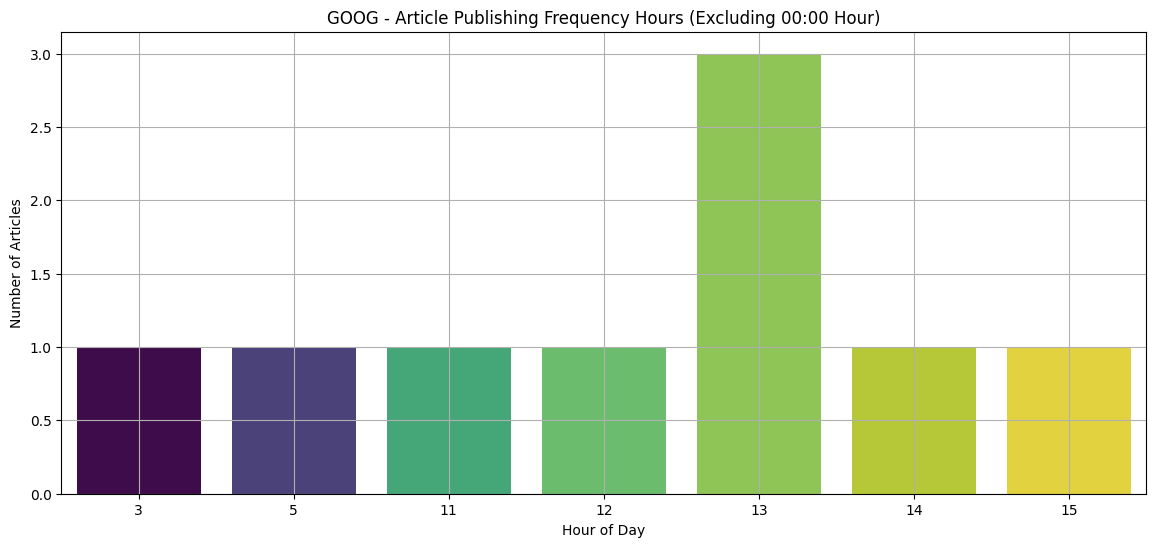

In [52]:
#plot and save the hourly publication frequency for hour other than 00:00 

#filter data for all other times
other_hours_data = GOOG_df[GOOG_df['publish_hour'] != 0]

#plot for 00:00
#Count articles per hour for other times
hourly_counts = other_hours_data['publish_hour'].value_counts().sort_index()

#plot
plt.figure(figsize=(14, 6))
sns.barplot(x=hourly_counts.index, y=hourly_counts.values, 
            hue=hourly_counts.index, palette='viridis', legend=False)
plt.title('GOOG - Article Publishing Frequency Hours (Excluding 00:00 Hour)')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Articles')
plt.xticks()
plt.grid() 


#select plot directory and plot name to save plot image
plot_folder = 'C:/Users/nuhamin/Documents/kifiya/week 1/' \
'Stock-Market-Price-Prediction-with-Sentiment-Analysis/' \
'plot images/news plot'

plot_name = 'GOOG - Article Publishing Frequency Hours (Excluding 00 00 Hour).png'
plot_path = os.path.join(plot_folder, plot_name)

#create the directory if it doesn't exist
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)

#save plot and display message
plt.savefig(plot_path)
print(f'\nPlot is saved.\n')

#display the plot
plt.show()

#close the plot to free up memory
plt.close()

## Publisher Analysis

In [53]:
#sentiment in the type of news specific publishers report

#analyse sentiment by publisher
sentiment_by_publisher = GOOG_df.groupby('publisher')['sentiment'].mean()
print('\nAverage sentiment by publisher:\n')
print(sentiment_by_publisher)


Average sentiment by publisher:

publisher
Alexis Raskin              0.000000
Amit Nag                   0.000000
Andrew Ward                0.011111
Benzinga Cannabis          0.100000
Benzinga Insights          0.000000
                             ...   
Zac Mannes                 0.000000
Zacks                      0.000000
luke@benzinga.com          0.005524
shivdeep@benzinga.com      0.250000
vishwanath@benzinga.com    0.000000
Name: sentiment, Length: 73, dtype: float64


In [54]:
#identify unique domains to check if  publisher is email adress instead of name
#extract the domain from each email address in the 'publisher' column
GOOG_df['domain'] = GOOG_df['publisher'].apply(lambda x: x.split('@')[-1] if '@' in x else 'Not an email')

#count the occurrences of each unique domain
domain_counts = GOOG_df['domain'].value_counts()

#display the domains with the highest counts (excluding 'Not an email' if it exists)
print('\nDomains with the most contributions:\n')
print(domain_counts[domain_counts.index != 'Not an email'].head())


Domains with the most contributions:

domain
benzinga.com    9
Name: count, dtype: int64


# **META** #

In [55]:
#assign df to a variable and display head
META_df = stock_dfs['FB']
META_df.head()

,date,headline,publisher,stock,url,sentiment
0,2020-06-10 16:20:19-04:00,As Expected: Fed Keeps Rates Unchanged and For...,JJ Kinahan,FB,https://www.benzinga.com/news/20/06/16226512/a...,-0.100000
1,2020-06-10 15:25:13-04:00,"Facebook, Snap Analyst Projects Q2 Revenue Ups...",Shanthi Rexaline,FB,https://www.benzinga.com/analyst-ratings/analy...,0.033333
2,2020-06-10 11:33:26-04:00,Tech Stocks And FAANGS Strong Again To Start D...,JJ Kinahan,FB,https://www.benzinga.com/government/20/06/1622...,0.433333
3,2020-06-10 00:52:01-04:00,Big Tech Reaches New Record Heights At The Sto...,Neer Varshney,FB,https://www.benzinga.com/news/20/06/16218615/b...,0.068182
4,2020-06-10 00:28:00-04:00,"Twitter, Square Will Mark Juneteenth As Holida...",Shivdeep Dhaliwal,FB,https://www.benzinga.com/news/20/06/16218441/t...,0.000000


## Descriptive Statistics

In [56]:
#display descriptive statistics for the 'headline' column
print("Descriptive statistics for 'headline' column:")
print(META_df['headline'].describe())

#get the number of unique headlines
print("\nNumber of unique headlines:")
print(META_df['headline'].nunique())

#calculate headline length
META_df['headline_length'] = META_df['headline'].apply(len)
print("\nBasic statistics for 'headline_length' column:")
print(META_df['headline_length'].describe())

#display the most frequent headlines
print("\nMost frequent headlines:")
print(META_df['headline'].value_counts().head())

Descriptive statistics for 'headline' column:
count                                   380
unique                                  371
top       Morning Market Stats in 5 Minutes
freq                                      5
Name: headline, dtype: object

Number of unique headlines:
371

Basic statistics for 'headline_length' column:
count    380.000000
mean      87.413158
std       46.016406
min       26.000000
25%       61.000000
50%       76.000000
75%       93.250000
max      290.000000
Name: headline_length, dtype: float64

Most frequent headlines:
headline
Morning Market Stats in 5 Minutes                                                                                                                                                                                               5
Facebook shares are trading higher after the company reported better-than-expected Q1 sales results and Q1 daily active users were up 11% year over year.                                                       

In [57]:
#count the number of articles per publisher 
print('Number of articles per publisher:\n')
print(META_df['publisher'].value_counts())

Number of articles per publisher:

publisher
Benzinga Newsdesk          102
Neer Varshney               56
Shivdeep Dhaliwal           29
IAM Newswire                22
JJ Kinahan                  21
Vick Meyer                  20
Lisa Levin                  19
Benzinga Insights           16
Wayne Duggan                12
Jayson Derrick               9
Benzinga_Newsdesk            9
ETF Professor                7
Tanzeel Akhtar               6
Elizabeth Balboa             6
Charles Gross                5
Nelson Hem                   4
vishwanath@benzinga.com      4
Shanthi Rexaline             3
Tyree Gorges                 3
Crystal Mills                3
Renato Capelj                3
Luke J Jacobi                2
Spencer Israel               2
TD Ameritrade Network        2
luke@benzinga.com            2
Hasan Saleem                 1
Eric Mancini                 1
Henry Khederian              1
AARP                         1
Benzinga Newsdesk            1
Joel Elconin             


Publication trends by day of the week:
publication_day
Thursday     124
Wednesday     83
Friday        57
Tuesday       55
Monday        51
Saturday       5
Sunday         5
Name: count, dtype: int64

Plot is saved.



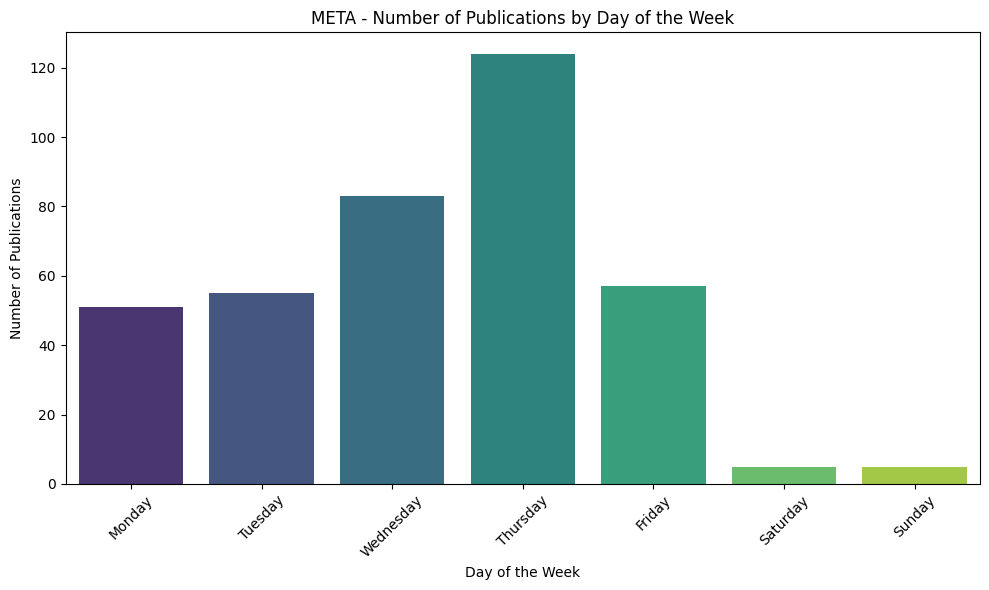

In [58]:
#analyse publication dates
META_df['publication_day'] = META_df['date'].dt.day_name()
print("\nPublication trends by day of the week:")
print(META_df['publication_day'].value_counts())

#plot publication dates and save plot image 
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
publication_day_counts = META_df['publication_day'].value_counts().reindex(day_order)

plt.figure(figsize=(10, 6))
sns.barplot(x=publication_day_counts.index, y=publication_day_counts.values, 
            hue=publication_day_counts.index, palette='viridis', legend=False)
plt.title('META - Number of Publications by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Publications')
plt.xticks(rotation=45)
plt.tight_layout()

#select plot directory and plot name to save plot
plot_folder = 'C:/Users/nuhamin/Documents/kifiya/week 1/' \
'Stock-Market-Price-Prediction-with-Sentiment-Analysis/' \
'plot images/news plot'

plot_name = 'META - Number of Publications by Day of the Week.png'
plot_path = os.path.join(plot_folder, plot_name)

#create the directory if it doesn't exist
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)

#save plot and display message
plt.savefig(plot_path)
print(f'\nPlot is saved.\n')
#display the plot
plt.show()

#close the plot to free up memory
plt.close()

## Sentiment Analysis

In [59]:

#calculate distribution of sentiment scores
print('Sentiment distribution:')
print(META_df['sentiment'].describe())

#analyse the sentiment of the most positive and negative headlines
#most positive headlines
most_positive_headlines = META_df.nlargest(5, 'sentiment')
print("\nMost Positive Headlines:")
print(most_positive_headlines[['headline', 'sentiment']])

#most negative headlines
most_negative_headlines = META_df.nsmallest(5, 'sentiment')
print("\nMost Negative Headlines:")
print(most_negative_headlines[['headline', 'sentiment']])

Sentiment distribution:
count    380.000000
mean       0.052653
std        0.195747
min       -0.800000
25%        0.000000
50%        0.000000
75%        0.067045
max        1.000000
Name: sentiment, dtype: float64

Most Positive Headlines:
                                              headline  sentiment
167  Munster Says Still 'Neutral' On Facebook's Lon...        1.0
303  Wedbush Maintains Outperform on Facebook, Main...        1.0
306  Hearing Wedbush Added Amazon, Peloton And Face...        1.0
310  Best Home Office Essentials During The COVID-1...        1.0
270  For Some Companies, A Sliver Of Good News Duri...        0.7

Most Negative Headlines:
                                              headline  sentiment
106  Facebook Removed 9.6M Posts For Hate Speech In...     -0.800
54   Trump Gets Mad Over Fact Check Warning On Twit...     -0.625
132  7 Times Elon Musk Wasn't Afraid To Speak His Mind     -0.600
37   Facebook Posts Blog Post Titled 'Verifying the...     -0.400
59   T


Plot is saved.



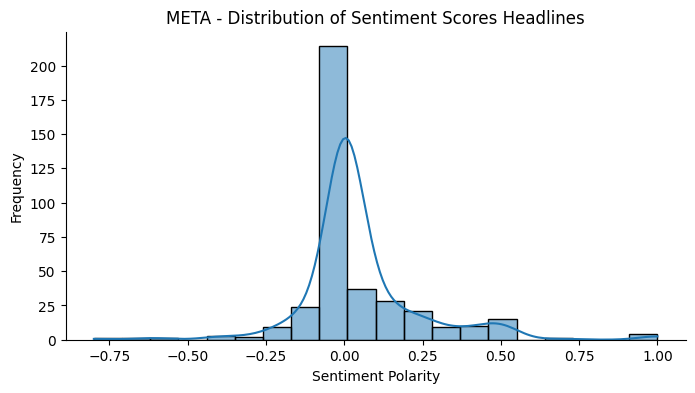

In [60]:
#plot the distribution of sentiment scores
plt.figure(figsize=(8, 4))
sns.histplot(META_df['sentiment'], bins=20, kde=True)
plt.title('META - Distribution of Sentiment Scores Headlines')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.gca().spines[['top', 'right']].set_visible(False)


#select plot directory and plot name to save plot image
plot_folder = 'C:/Users/nuhamin/Documents/kifiya/week 1/' \
'Stock-Market-Price-Prediction-with-Sentiment-Analysis/' \
'plot images/news plot'

plot_name = 'META - Distribution of Sentiment Scores Headlines.png'
plot_path = os.path.join(plot_folder, plot_name)

#create the directory if it doesn't exist
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)

#save plot and display message
plt.savefig(plot_path)
print(f'\nPlot is saved.\n')

#display the plot
plt.show()

#close the plot to free up memory
plt.close()

## Text Analysis (Topic Modelling)

In [61]:
#preproces dataframe
  #Converting to lowercase.
  #Removing non-alphanumeric characters (except spaces).
  #Tokenizing the text into words.
  #Removing common English stop words.
  #Lemmatizing words to their base form.

META_text_data = META_df['headline'].dropna().tolist() 

def preprocess_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char.isalnum() or char.isspace()]) #keep alphanumeric and spaces
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

processed_META_text_data = [preprocess_text(text) for text in META_text_data]

In [62]:
#calculate Term Frequency-Inverse Document Frequency (TF-IDF) to identify important terms

#initalise tfidf_vectorizer for upto 1000 single words and two-word phrases 
tfidf_vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2)) #consider unigrams and bigrams

#calculate tfidf_matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(processed_META_text_data)

#get feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

#iterate through each articles to find overall important terms
#terms with highest TF-IDF scores across all documents
print('\nTop TF-IDF terms:\n')

#calculate Average TF-IDF scores
#'.A1' converts the result matrix of means into a 1-dimensional array
average_tfidf = tfidf_matrix.mean(axis=0).A1

#sort and get top terms
sorted_tfidf_indices = average_tfidf.argsort()[::-1]
top_tfidf_terms = [(feature_names[i], average_tfidf[i]) for i in sorted_tfidf_indices[:20]] #top 20
for term, score in top_tfidf_terms:
    print(f'{term}: {score:.4f}')


Top TF-IDF terms:

facebook: 0.0523
coronavirus: 0.0309
stock: 0.0268
say: 0.0220
market: 0.0206
price: 0.0197
share: 0.0191
earnings: 0.0191
target: 0.0180
company: 0.0175
medium: 0.0175
price target: 0.0174
social: 0.0167
maintains: 0.0165
facebooks: 0.0160
buy: 0.0158
trump: 0.0154
social medium: 0.0152
twitter: 0.0136
raise: 0.0134


In [63]:
#topic Modeling with LDA
num_topics = 10
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(tfidf_matrix)

print(f'\nTopics discovered by LDA ({num_topics} topics):')
for index, topic in enumerate(lda.components_):
    print(f'Topic #{index + 1}:')
    top_words = [feature_names[i] for i in topic.argsort()[-10:]] #get top 10 words for each topic
    print(', '.join(top_words))


Topics discovered by LDA (10 topics):
Topic #1:
case, alphabet, facebook, 52week high, fang, hit, mark, stock hit, hit 52week, 52week
Topic #2:
several communication, trading lower, coronavirus, communication, share, company, trading, company trading, share several, several
Topic #3:
exposure, facebook, home, work, employee work, work home, coronavirus, facebooks, employee, time
Topic #4:
say, chip, look, stock, facebooks, news, share, earnings, facebook, etf
Topic #5:
cryptocurrency, premarket session, communication service, moving, premarket, service, stock moving, session, stock, facebook
Topic #6:
fed, q1, bias, thursday premarket, facebook pay, cryptocurrency, facebook, user, pay, year
Topic #7:
stock, upgrade, share, facebook, april, 30, 2020, moving thursday, biggest, coronavirus
Topic #8:
future, say, market, executive order, executive, trump, order, medium, social medium, social
Topic #9:
ubs, ubs maintains, home, work, mark, facebook, mark zuckerberg, lower, facebook lower, 

In [64]:
#named Entity Recognition with spaCy
print('\nNamed Entities (using spaCy - for the first 10 articles):\n')
for i, text in enumerate(META_text_data[:10]): #process 10 
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    if entities:
        print(f'Article {i + 1}: {entities}')
    else:
        print(f'Article {i + 1}: No named entities found.')


Named Entities (using spaCy - for the first 10 articles):

Article 1: [('Forecasts Years', 'WORK_OF_ART'), ('Dovish', 'NORP')]
Article 2: No named entities found.
Article 3: [('FAANGS Strong Again', 'PERSON')]
Article 4: [('Big Tech Reaches New Record Heights', 'ORG')]
Article 5: [('Honor African-American', 'NORP')]
Article 6: [('5 Minutes', 'TIME')]
Article 7: No named entities found.
Article 8: [('IRS Alerts Against Criminals Profiteering From Fake Coronavirus Treatments', 'ORG')]
Article 9: [('5 Minutes', 'TIME')]
Article 10: [('$750M', 'MONEY'), ('Abu Dhabi Sovereign Fund', 'ORG'), ('Walmart', 'ORG'), ('India', 'GPE')]


## Time Series Analysis


Plot is saved.



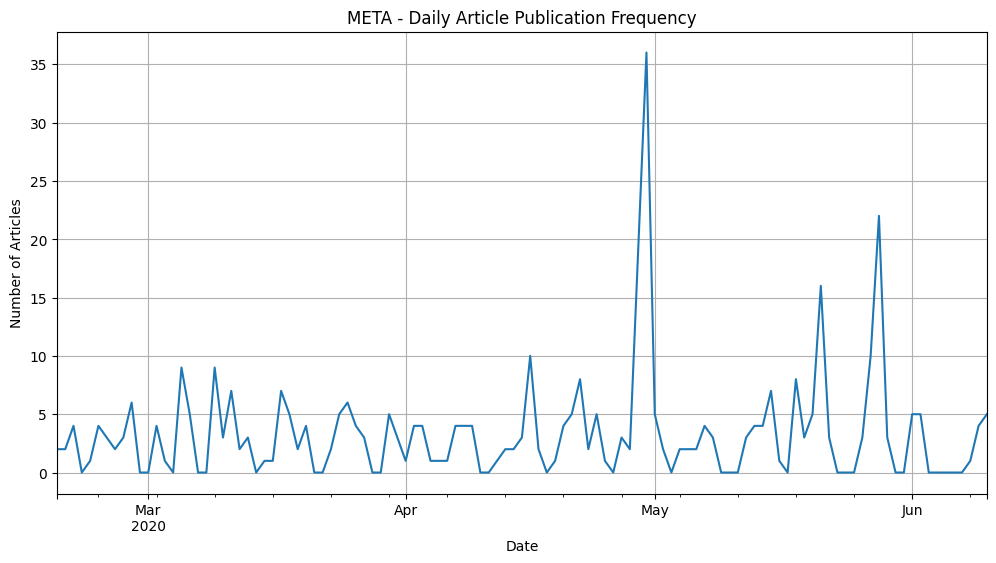

In [65]:
#plot and save the daily publication frequency

#resample to daily frequency and count publications
daily_publications = META_df.resample('D', on='date').size()

#plot
plt.figure(figsize=(12, 6))
daily_publications.plot()
plt.title('META - Daily Article Publication Frequency')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.grid()


#select plot directory and plot name to save plot image
plot_folder = 'C:/Users/nuhamin/Documents/kifiya/week 1/' \
'Stock-Market-Price-Prediction-with-Sentiment-Analysis/' \
'plot images/news plot'

plot_name = 'META - Daily Article Publication Frequency.png'
plot_path = os.path.join(plot_folder, plot_name)

#create the directory if it doesn't exist
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)

#save plot and display message
plt.savefig(plot_path)
print(f'\nPlot is saved.\n')

#display the plot
plt.show()

#close the plot to free up memory
plt.close()


Number of articles published at 00:00 is 372


Plot is saved.



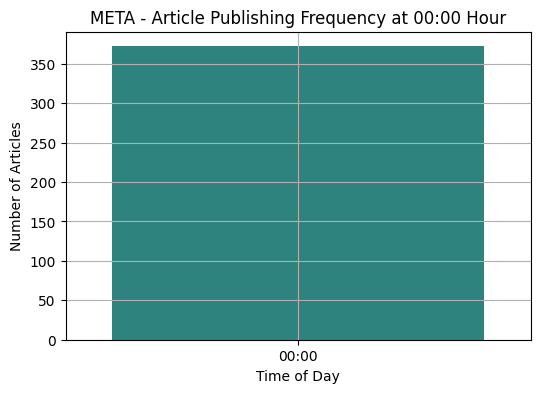

In [66]:
#plot and save the hourly publication frequency for 00:00 hour

#extract the hour from the datetime column
META_df['publish_hour'] = pd.to_datetime(META_df['date']).dt.hour

#filter data for 00:00
zero_hour_data = META_df[META_df['publish_hour'] == 0]

#calculate and print the count of articles published at 00:00
zero_hour_count = len(zero_hour_data)
print(f'\nNumber of articles published at 00:00 is {zero_hour_count}\n')

#plot for 00:00
#Create a small DataFrame 
plot_data = pd.DataFrame({'hour': ['00:00'], 'count': [zero_hour_count]})

plt.figure(figsize=(6, 4))
sns.barplot(x='hour', y='count', data=plot_data, hue='hour', palette='viridis', legend=False)
plt.title('META - Article Publishing Frequency at 00:00 Hour')
plt.xlabel('Time of Day')
plt.ylabel('Number of Articles')
plt.grid()


#select plot directory and plot name to save plot image
plot_folder = 'C:/Users/nuhamin/Documents/kifiya/week 1/' \
'Stock-Market-Price-Prediction-with-Sentiment-Analysis/' \
'plot images/news plot'

plot_name = 'META - Article Publishing Frequency at 00 00 Hour.png'
plot_path = os.path.join(plot_folder, plot_name)

#create the directory if it doesn't exist
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)

#save plot and display message
plt.savefig(plot_path)
print(f'\nPlot is saved.\n')

#display the plot
plt.show()

#close the plot to free up memory
plt.close()


Plot is saved.



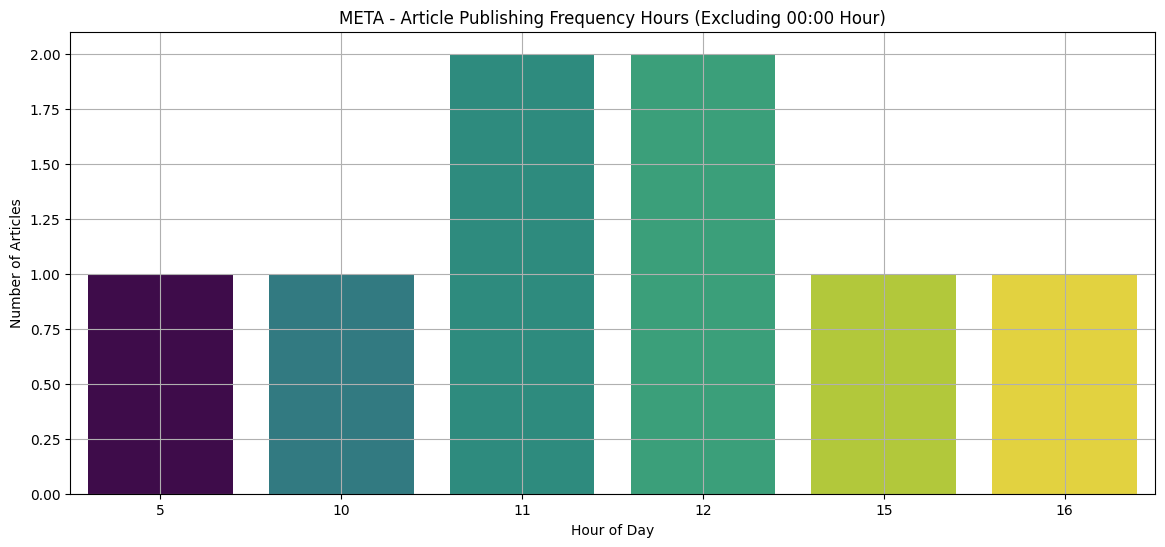

In [67]:
#plot and save the hourly publication frequency for hour other than 00:00 

#filter data for all other times
other_hours_data = META_df[META_df['publish_hour'] != 0]

#plot for 00:00
#Count articles per hour for other times
hourly_counts = other_hours_data['publish_hour'].value_counts().sort_index()

#plot
plt.figure(figsize=(14, 6))
sns.barplot(x=hourly_counts.index, y=hourly_counts.values, 
            hue=hourly_counts.index, palette='viridis', legend=False)
plt.title('META - Article Publishing Frequency Hours (Excluding 00:00 Hour)')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Articles')
plt.xticks()
plt.grid() 


#select plot directory and plot name to save plot image
plot_folder = 'C:/Users/nuhamin/Documents/kifiya/week 1/' \
'Stock-Market-Price-Prediction-with-Sentiment-Analysis/' \
'plot images/news plot'

plot_name = 'META - Article Publishing Frequency Hours (Excluding 00 00 Hour).png'
plot_path = os.path.join(plot_folder, plot_name)

#create the directory if it doesn't exist
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)

#save plot and display message
plt.savefig(plot_path)
print(f'\nPlot is saved.\n')

#display the plot
plt.show()

#close the plot to free up memory
plt.close()

## Publisher Analysis

In [68]:
#sentiment in the type of news specific publishers report

#analyse sentiment by publisher
sentiment_by_publisher = META_df.groupby('publisher')['sentiment'].mean()
print('\nAverage sentiment by publisher:\n')
print(sentiment_by_publisher)


Average sentiment by publisher:

publisher
AARP                       0.017857
Benzinga Insights          0.000000
Benzinga Newsdesk          0.066313
Benzinga Staff             0.500000
Benzinga_Newsdesk          0.159609
Benzinga Newsdesk         -0.014236
Charles Gross              0.014167
Craig Jones                0.200000
Crystal Mills              0.068981
ETF Professor              0.064286
Elizabeth Balboa          -0.094444
Eric Mancini               0.100000
FreightWaves               0.000000
Hasan Saleem               0.350000
Henry Khederian            0.500000
IAM Newswire               0.058409
JJ Kinahan                 0.091426
Jason Shubnell             0.000000
Jaycee Tenn                0.200000
Jayson Derrick             0.085859
Joel Elconin               0.000000
Khyathi Dalal              0.000000
Lisa Levin                 0.031287
Luke J Jacobi              0.041369
Neer Varshney             -0.000740
Nelson Hem                 0.500000
Randy Elias         

In [69]:
#identify unique domains to check if  publisher is email adress instead of name
#extract the domain from each email address in the 'publisher' column
META_df['domain'] = META_df['publisher'].apply(lambda x: x.split('@')[-1] if '@' in x else 'Not an email')

#count the occurrences of each unique domain
domain_counts = META_df['domain'].value_counts()

#display the domains with the highest counts (excluding 'Not an email' if it exists)
print('\nDomains with the most contributions:\n')
print(domain_counts[domain_counts.index != 'Not an email'].head())


Domains with the most contributions:

domain
benzinga.com    6
Name: count, dtype: int64


# **MSFT** #

In [70]:
#assign df to a variable and display head
MSFT_df = stock_dfs['MSF']
MSFT_df.head()

,date,headline,publisher,stock,url,sentiment
0,2019-10-21 19:21:40-04:00,NVIDIA with Microsoft Announces Technology Col...,Charles Gross,MSF,https://www.benzinga.com/news/19/10/14632016/n...,0.800000
1,2018-10-08 11:13:38-04:00,"LinkedIn to Acquire Glint, An Employee Engagem...",Benzinga Newsdesk,MSF,https://www.benzinga.com/news/18/10/12472271/l...,0.000000
2,2018-09-13 10:19:43-04:00,"Stocks Which Set New 52-Week Low Yesterday, Se...",Benzinga Newsdesk,MSF,https://www.benzinga.com/trading-ideas/technic...,0.068182
3,2018-09-12 15:29:45-04:00,"Stocks Which Set New 52-Week Low Yesterday, Se...",Benzinga Newsdesk,MSF,https://www.benzinga.com/trading-ideas/technic...,0.068182
4,2018-09-10 16:38:26-04:00,"Stocks Which Set New 52-Week Low Friday, Septe...",Benzinga Newsdesk,MSF,https://www.benzinga.com/trading-ideas/technic...,0.068182


## Descriptive Statistics

In [71]:
#display descriptive statistics for the 'headline' column
print("Descriptive statistics for 'headline' column:")
print(MSFT_df['headline'].describe())

#get the number of unique headlines
print("\nNumber of unique headlines:")
print(MSFT_df['headline'].nunique())

#calculate headline length
MSFT_df['headline_length'] = MSFT_df['headline'].apply(len)
print("\nBasic statistics for 'headline_length' column:")
print(MSFT_df['headline_length'].describe())

#display the most frequent headlines
print("\nMost frequent headlines:")
print(MSFT_df['headline'].value_counts().head())

Descriptive statistics for 'headline' column:
count                                                    12
unique                                                   12
top       NVIDIA with Microsoft Announces Technology Col...
freq                                                      1
Name: headline, dtype: object

Number of unique headlines:
12

Basic statistics for 'headline_length' column:
count    12.000000
mean     64.166667
std      13.583635
min      47.000000
25%      56.500000
50%      57.500000
75%      77.250000
max      88.000000
Name: headline_length, dtype: float64

Most frequent headlines:
headline
NVIDIA with Microsoft Announces Technology Collaboration for Era of Intelligent Edge    1
LinkedIn to Acquire Glint, An Employee Engagement Company                               1
Stocks Which Set New 52-Week Low Yesterday, September 12th                              1
Stocks Which Set New 52-Week Low Yesterday, September 11th                              1
Stocks Which Set Ne

In [72]:
#count the number of articles per publisher 
print('Number of articles per publisher:\n')
print(MSFT_df['publisher'].value_counts())

Number of articles per publisher:

publisher
Benzinga Newsdesk    7
Charles Gross        1
Paul Quintaro        1
Brett Hershman       1
Taylor Cox           1
SmallCapVoice        1
Name: count, dtype: int64



Publication trends by day of the week:
publication_day
Monday       4
Thursday     4
Friday       2
Wednesday    1
Tuesday      1
Name: count, dtype: int64

Plot is saved.



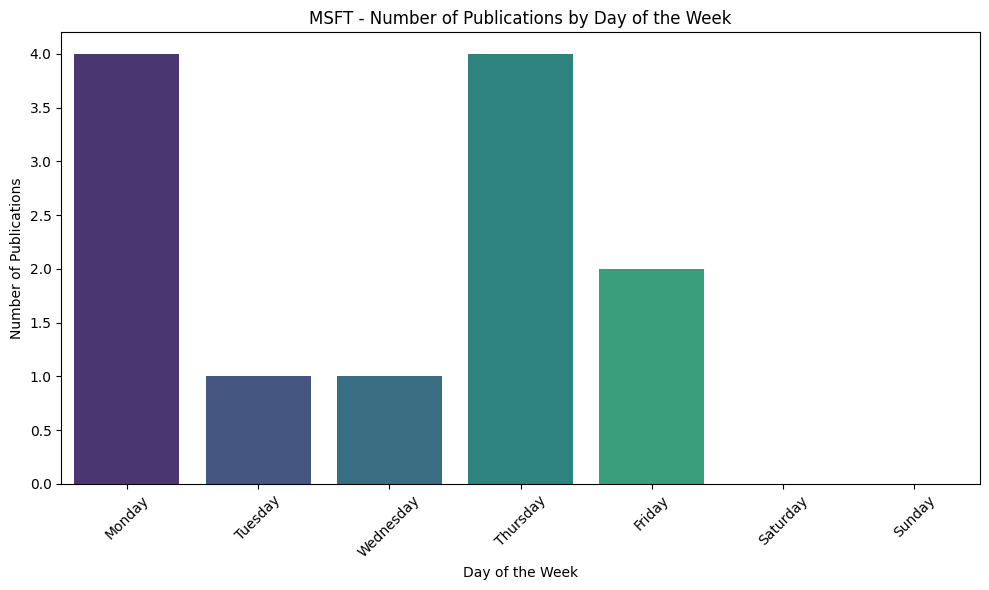

In [73]:
#analyse publication dates
MSFT_df['publication_day'] = MSFT_df['date'].dt.day_name()
print("\nPublication trends by day of the week:")
print(MSFT_df['publication_day'].value_counts())

#plot publication dates and save plot image 
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
publication_day_counts = MSFT_df['publication_day'].value_counts().reindex(day_order)

plt.figure(figsize=(10, 6))
sns.barplot(x=publication_day_counts.index, y=publication_day_counts.values, 
            hue=publication_day_counts.index, palette='viridis', legend=False)
plt.title('MSFT - Number of Publications by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Publications')
plt.xticks(rotation=45)
plt.tight_layout()

#select plot directory and plot name to save plot
plot_folder = 'C:/Users/nuhamin/Documents/kifiya/week 1/' \
'Stock-Market-Price-Prediction-with-Sentiment-Analysis/' \
'plot images/news plot'

plot_name = 'MSFT - Number of Publications by Day of the Week.png'
plot_path = os.path.join(plot_folder, plot_name)

#create the directory if it doesn't exist
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)

#save plot and display message
plt.savefig(plot_path)
print(f'\nPlot is saved.\n')

#display the plot
plt.show()

#close the plot to free up memory
plt.close()

## Sentiment Analysis

In [74]:

#calculate distribution of sentiment scores
print('Sentiment distribution:')
print(MSFT_df['sentiment'].describe())

#analyse the sentiment of the most positive and negative headlines
#most positive headlines
most_positive_headlines = MSFT_df.nlargest(5, 'sentiment')
print("\nMost Positive Headlines:")
print(most_positive_headlines[['headline', 'sentiment']])

#most negative headlines
most_negative_headlines = MSFT_df.nsmallest(5, 'sentiment')
print("\nMost Negative Headlines:")
print(most_negative_headlines[['headline', 'sentiment']])

Sentiment distribution:
count    12.000000
mean      0.132008
std       0.256622
min      -0.125000
25%       0.000000
50%       0.068182
75%       0.068182
max       0.800000
Name: sentiment, dtype: float64

Most Positive Headlines:
                                            headline  sentiment
0  NVIDIA with Microsoft Announces Technology Col...   0.800000
9    Where The Top 5 Tech Firms Derive Their Revenue   0.500000
2  Stocks Which Set New 52-Week Low Yesterday, Se...   0.068182
3  Stocks Which Set New 52-Week Low Yesterday, Se...   0.068182
4  Stocks Which Set New 52-Week Low Friday, Septe...   0.068182

Most Negative Headlines:
                                             headline  sentiment
11  4-6-10 Daily Small Cap Market News and Stock H...  -0.125000
1   LinkedIn to Acquire Glint, An Employee Engagem...   0.000000
8   UPDATE: Polygon Article Speculates Valve, PUBG...   0.000000
10  2 Boutique Financial Firms To Make Millions Ad...   0.000000
2   Stocks Which Set New 52-Wee


Plot is saved.



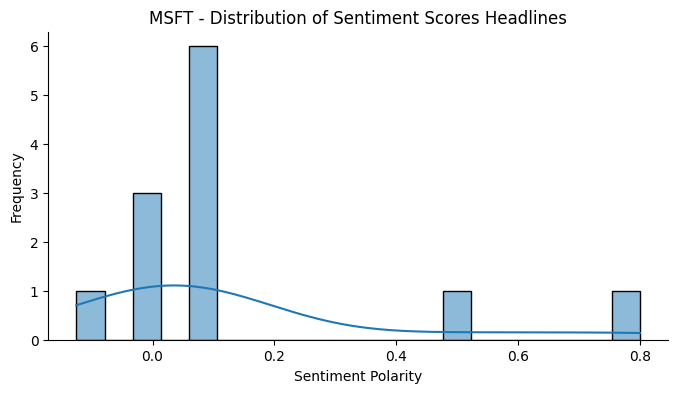

In [75]:
#plot the distribution of sentiment scores
plt.figure(figsize=(8, 4))
sns.histplot(MSFT_df['sentiment'], bins=20, kde=True)
plt.title('MSFT - Distribution of Sentiment Scores Headlines')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.gca().spines[['top', 'right']].set_visible(False)


#select plot directory and plot name to save plot image
plot_folder = 'C:/Users/nuhamin/Documents/kifiya/week 1/' \
'Stock-Market-Price-Prediction-with-Sentiment-Analysis/' \
'plot images/news plot'

plot_name = 'MSFT - Distribution of Sentiment Scores Headlines.png'
plot_path = os.path.join(plot_folder, plot_name)

#create the directory if it doesn't exist
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)

#save plot and display message
plt.savefig(plot_path)
print(f'\nPlot is saved.\n')

#display the plot
plt.show()

#close the plot to free up memory
plt.close()

## Text Analysis (Topic Modelling)

In [76]:
#preproces dataframe
  #Converting to lowercase.
  #Removing non-alphanumeric characters (except spaces).
  #Tokenizing the text into words.
  #Removing common English stop words.
  #Lemmatizing words to their base form.

MSFT_text_data = MSFT_df['headline'].dropna().tolist() 

def preprocess_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char.isalnum() or char.isspace()]) #keep alphanumeric and spaces
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

processed_MSFT_text_data = [preprocess_text(text) for text in MSFT_text_data]

In [77]:
#calculate Term Frequency-Inverse Document Frequency (TF-IDF) to identify important terms

#initalise tfidf_vectorizer for upto 1000 single words and two-word phrases 
tfidf_vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2)) #consider unigrams and bigrams

#calculate tfidf_matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(processed_MSFT_text_data)

#get feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

#iterate through each articles to find overall important terms
#terms with highest TF-IDF scores across all documents
print('\nTop TF-IDF terms:\n')

#calculate Average TF-IDF scores
#'.A1' converts the result matrix of means into a 1-dimensional array
average_tfidf = tfidf_matrix.mean(axis=0).A1

#sort and get top terms
sorted_tfidf_indices = average_tfidf.argsort()[::-1]
top_tfidf_terms = [(feature_names[i], average_tfidf[i]) for i in sorted_tfidf_indices[:20]] #top 20
for term, score in top_tfidf_terms:
    print(f'{term}: {score:.4f}')


Top TF-IDF terms:

stock: 0.1095
stock set: 0.1077
set: 0.1077
new 52week: 0.1077
new: 0.1077
set new: 0.1077
low: 0.1077
52week low: 0.1077
52week: 0.1077
low yesterday: 0.0999
yesterday: 0.0999
september: 0.0992
yesterday september: 0.0896
firm: 0.0417
microsoft: 0.0352
september 5th: 0.0329
september 11th: 0.0329
september 6th: 0.0329
september 12th: 0.0329
12th: 0.0329


In [78]:
#topic Modeling with LDA
num_topics = 10
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(tfidf_matrix)

print(f'\nTopics discovered by LDA ({num_topics} topics):')
for index, topic in enumerate(lda.components_):
    print(f'Topic #{index + 1}:')
    top_words = [feature_names[i] for i in topic.argsort()[-10:]] #get top 10 words for each topic
    print(', '.join(top_words))


Topics discovered by LDA (10 topics):
Topic #1:
set, stock set, new 52week, set new, low yesterday, yesterday, september, yesterday september, 6th, september 6th
Topic #2:
acquire glint, company, linkedin acquire, engagement, engagement company, employee, linkedin, glint, employee engagement, glint employee
Topic #3:
set, new 52week, yesterday, low yesterday, august, august 15th, 15th, yesterday august, 5th, september 5th
Topic #4:
market news, smallcapvoicecom, small cap, news, small, microsoft, 6th, september 6th, 5th, september 5th
Topic #5:
market news, smallcapvoicecom, small cap, news, small, microsoft, 6th, september 6th, 5th, september 5th
Topic #6:
low yesterday, 52week, 52week low, low, set new, new, new 52week, set, stock set, stock
Topic #7:
market news, smallcapvoicecom, small cap, news, small, microsoft, 6th, september 6th, 5th, september 5th
Topic #8:
pubg could, pubg, possible purchase, purchase microsoft, update, speculates, speculates valve, valve pubg, valve, update

In [79]:
#named Entity Recognition with spaCy
print('\nNamed Entities (using spaCy - for all articles):\n')
for i, text in enumerate(MSFT_text_data[:12]): #process all
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    if entities:
        print(f'Article {i + 1}: {entities}')
    else:
        print(f'Article {i + 1}: No named entities found.')


Named Entities (using spaCy - for all articles):

Article 1: [('Microsoft Announces Technology Collaboration for Era of Intelligent Edge', 'ORG')]
Article 2: [('Acquire Glint', 'PERSON'), ('An Employee Engagement Company', 'ORG')]
Article 3: [('52-Week', 'DATE'), ('Yesterday, September 12th', 'DATE')]
Article 4: [('52-Week', 'DATE'), ('Yesterday, September 11th', 'DATE')]
Article 5: [('52-Week', 'DATE'), ('Friday, September 7th', 'DATE')]
Article 6: [('52-Week', 'DATE'), ('Yesterday, September 6th', 'DATE')]
Article 7: [('52-Week', 'DATE'), ('Yesterday, September 5th', 'DATE')]
Article 8: [('52-Week', 'DATE'), ('Yesterday, August 15th', 'DATE')]
Article 9: [('Polygon', 'ORG'), ('Speculates Valve', 'PERSON'), ('Microsoft', 'ORG')]
Article 10: No named entities found.
Article 11: [('2', 'CARDINAL')]
Article 12: [('4', 'CARDINAL')]


## Time Series Analysis


Plot is saved.



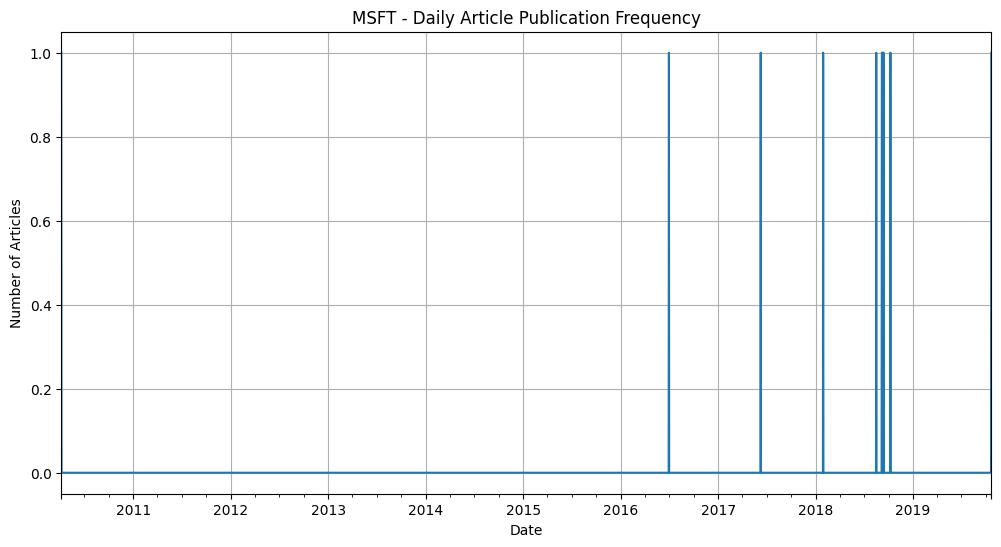

In [80]:
#plot and save the daily publication frequency

#resample to daily frequency and count publications
daily_publications = MSFT_df.resample('D', on='date').size()

#plot
plt.figure(figsize=(12, 6))
daily_publications.plot()
plt.title('MSFT - Daily Article Publication Frequency')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.grid()


#select plot directory and plot name to save plot image
plot_folder = 'C:/Users/nuhamin/Documents/kifiya/week 1/' \
'Stock-Market-Price-Prediction-with-Sentiment-Analysis/' \
'plot images/news plot'

plot_name = 'MSFT - Daily Article Publication Frequency.png'
plot_path = os.path.join(plot_folder, plot_name)

#create the directory if it doesn't exist
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)

#save plot and display message
plt.savefig(plot_path)
print(f'\nPlot is saved.\n')

#display the plot
plt.show()

#close the plot to free up memory
plt.close()


Plot is saved.



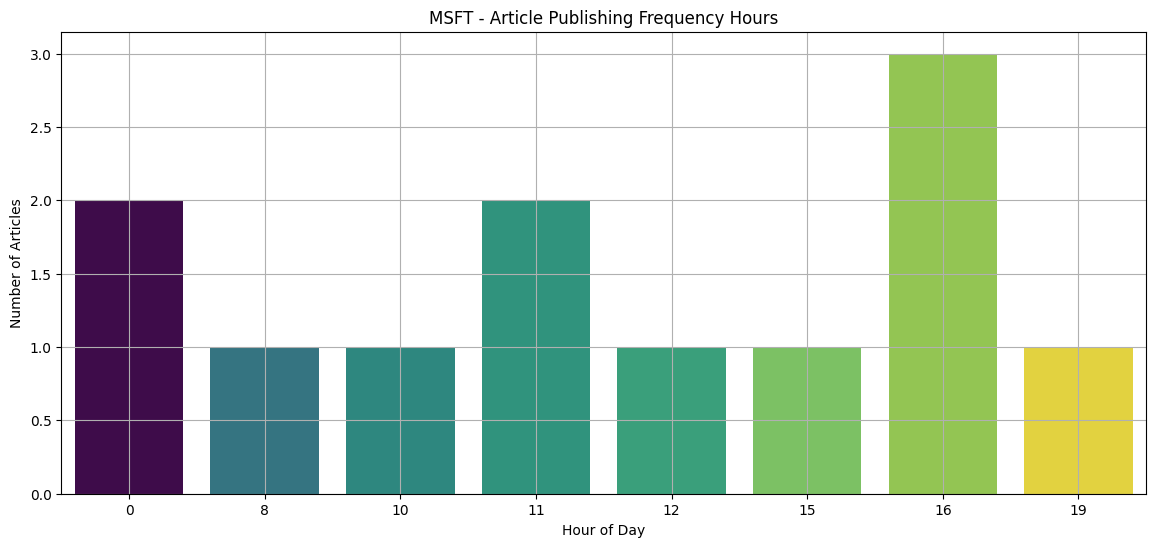

In [81]:
#plot and save the hourly publication frequency 

#extract the hour from the datetime column
MSFT_df['publish_hour'] = pd.to_datetime(MSFT_df['date']).dt.hour
hours_data = MSFT_df['publish_hour']


#plot
#Count articles per hour
hourly_counts = hours_data.value_counts().sort_index()

plt.figure(figsize=(14, 6))
sns.barplot(x=hourly_counts.index, y=hourly_counts.values, 
            hue=hourly_counts.index, palette='viridis', legend=False)
plt.title('MSFT - Article Publishing Frequency Hours')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Articles')
plt.xticks()
plt.grid() 


#select plot directory and plot name to save plot image
plot_folder = 'C:/Users/nuhamin/Documents/kifiya/week 1/' \
'Stock-Market-Price-Prediction-with-Sentiment-Analysis/' \
'plot images/news plot'

plot_name = 'MSFT - Article Publishing Frequency Hours.png'
plot_path = os.path.join(plot_folder, plot_name)

#create the directory if it doesn't exist
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)

#save plot and display message
plt.savefig(plot_path)
print(f'\nPlot is saved.\n')

#display the plot
plt.show()

#close the plot to free up memory
plt.close()

## Publisher Analysis

In [82]:
#sentiment in the type of news specific publishers report

#analyse sentiment by publisher
sentiment_by_publisher = MSFT_df.groupby('publisher')['sentiment'].mean()
print('\nAverage sentiment by publisher:\n')
print(sentiment_by_publisher)


Average sentiment by publisher:

publisher
Benzinga Newsdesk    0.058442
Brett Hershman       0.500000
Charles Gross        0.800000
Paul Quintaro        0.000000
SmallCapVoice       -0.125000
Taylor Cox           0.000000
Name: sentiment, dtype: float64


In [83]:
#identify unique domains to check if  publisher is email adress instead of name
#extract the domain from each email address in the 'publisher' column
MSFT_df['domain'] = MSFT_df['publisher'].apply(lambda x: x.split('@')[-1] if '@' in x else 'Not an email')

#count the occurrences of each unique domain
domain_counts = MSFT_df['domain'].value_counts()

#display the domains with the highest counts (excluding 'Not an email' if it exists)
print('\nDomains with the most contributions:\n')
print(domain_counts[domain_counts.index != 'Not an email'].head())


Domains with the most contributions:

Series([], Name: count, dtype: int64)


# **NVDA** #

In [84]:
#assign df to a variable and display head
NVDA_df = stock_dfs['NVDA']
NVDA_df.head()

,date,headline,publisher,stock,url,sentiment
0,2020-06-10 12:37:10-04:00,Shares of several technology companies are tra...,Benzinga Newsdesk,NVDA,https://www.benzinga.com/wiim/20/06/16224173/s...,0.08125
1,2020-06-10 12:12:25-04:00,Afternoon Market Stats in 5 Minutes,Benzinga Insights,NVDA,https://www.benzinga.com/markets/20/06/1622357...,0.00000
2,2020-06-10 10:22:11-04:00,Morning Market Stats in 5 Minutes,Benzinga Insights,NVDA,https://www.benzinga.com/markets/20/06/1622174...,0.00000
3,2020-06-09 13:40:43-04:00,Shares of several technology companies are tra...,Benzinga Newsdesk,NVDA,https://www.benzinga.com/wiim/20/06/16214789/s...,0.26250
4,2020-06-08 12:30:29-04:00,Afternoon Market Stats in 5 Minutes,Benzinga Insights,NVDA,https://www.benzinga.com/markets/20/06/1620319...,0.00000


## Descriptive Statistics

In [85]:
#display descriptive statistics for the 'headline' column
print("Descriptive statistics for 'headline' column:")
print(NVDA_df['headline'].describe())

#get the number of unique headlines
print("\nNumber of unique headlines:")
print(NVDA_df['headline'].nunique())

#calculate headline length
NVDA_df['headline_length'] = NVDA_df['headline'].apply(len)
print("\nBasic statistics for 'headline_length' column:")
print(NVDA_df['headline_length'].describe())

#display the most frequent headlines
print("\nMost frequent headlines:")
print(NVDA_df['headline'].value_counts().head())

Descriptive statistics for 'headline' column:
count                             3146
unique                            2988
top       Stocks Hitting 52-Week Highs
freq                                17
Name: headline, dtype: object

Number of unique headlines:
2988

Basic statistics for 'headline_length' column:
count    3146.000000
mean       76.813732
std        47.904001
min        16.000000
25%        47.000000
50%        64.000000
75%        85.000000
max       382.000000
Name: headline_length, dtype: float64

Most frequent headlines:
headline
Stocks Hitting 52-Week Highs                 17
Benzinga's Top Upgrades                      17
The Market In 5 Minutes                      10
Benzinga's Top Pre-Market Losers              8
5 Biggest Price Target Changes For Friday     7
Name: count, dtype: int64


In [86]:
#count the number of articles per publisher 
print('Number of articles per publisher:\n')
print(NVDA_df['publisher'].value_counts())

Number of articles per publisher:

publisher
Lisa Levin           357
Benzinga Newsdesk    346
Paul Quintaro        293
Charles Gross        191
Wayne Duggan         144
                    ... 
Michael R Foster       1
Hilary Farrell         1
Patrick Henderson      1
Ryan Mallory           1
Mark Page              1
Name: count, Length: 152, dtype: int64



Publication trends by day of the week:
publication_day
Friday       740
Thursday     712
Monday       567
Tuesday      550
Wednesday    505
Sunday        41
Saturday      31
Name: count, dtype: int64

Plot is saved.



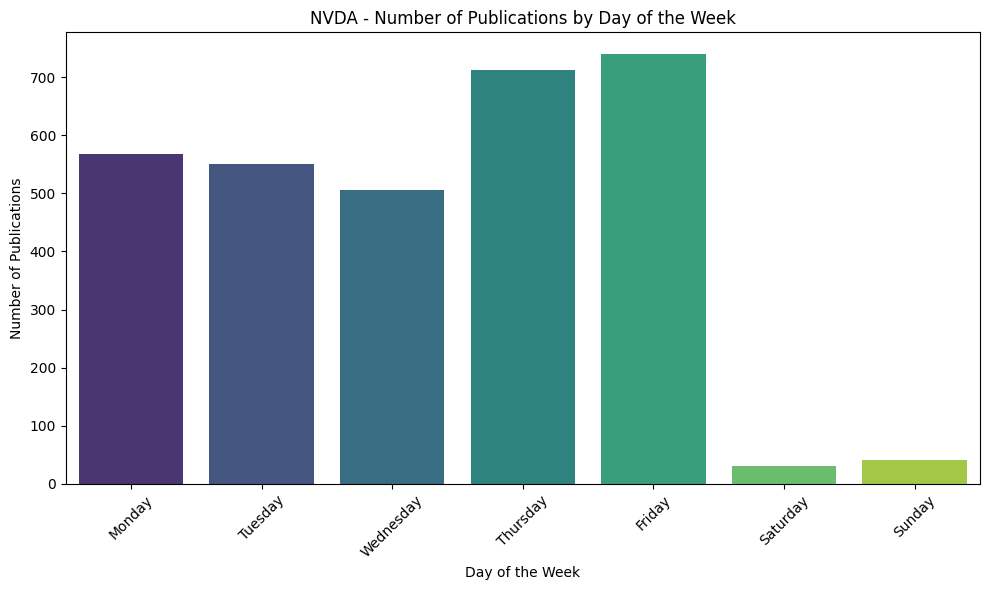

In [87]:
#analyse publication dates
NVDA_df['publication_day'] = NVDA_df['date'].dt.day_name()
print("\nPublication trends by day of the week:")
print(NVDA_df['publication_day'].value_counts())

#plot publication dates and save plot image 
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
publication_day_counts = NVDA_df['publication_day'].value_counts().reindex(day_order)

plt.figure(figsize=(10, 6))
sns.barplot(x=publication_day_counts.index, y=publication_day_counts.values, 
            hue=publication_day_counts.index, palette='viridis', legend=False)
plt.title('NVDA - Number of Publications by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Publications')
plt.xticks(rotation=45)
plt.tight_layout()

#select plot directory and plot name to save plot
plot_folder = 'C:/Users/nuhamin/Documents/kifiya/week 1/' \
'Stock-Market-Price-Prediction-with-Sentiment-Analysis/' \
'plot images/news plot'

plot_name = 'NVDA - Number of Publications by Day of the Week.png'
plot_path = os.path.join(plot_folder, plot_name)

#create the directory if it doesn't exist
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)

#save plot and display message
plt.savefig(plot_path)
print(f'\nPlot is saved.\n')

#display the plot
plt.show()

#close the plot to free up memory
plt.close()

## Sentiment Analysis

In [88]:

#calculate distribution of sentiment scores
print('Sentiment distribution:')
print(NVDA_df['sentiment'].describe())

#analyse the sentiment of the most positive and negative headlines
#most positive headlines
most_positive_headlines = NVDA_df.nlargest(5, 'sentiment')
print("\nMost Positive Headlines:")
print(most_positive_headlines[['headline', 'sentiment']])

#most negative headlines
most_negative_headlines = NVDA_df.nsmallest(5, 'sentiment')
print("\nMost Negative Headlines:")
print(most_negative_headlines[['headline', 'sentiment']])

Sentiment distribution:
count    3146.000000
mean        0.073766
std         0.199379
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.125000
max         1.000000
Name: sentiment, dtype: float64

Most Positive Headlines:
                                               headline  sentiment
313                                 5 Best ETFs Of 2019        1.0
341            Decoding AMD's Breathtaking 2-Year Rally        1.0
398   Shoppers Rise To The Occasion As Walmart Repor...        1.0
854   This Leveraged ETF Rapidly Became One Of Novem...        1.0
1344  Bitcoin, China, And AI Highlight Some Of The Y...        1.0

Most Negative Headlines:
                                               headline  sentiment
1390  Traders See Signs Of Rotation Into Financials ...      -1.00
2046  Worst Performing Industries For November 14, 2016      -1.00
1656  'Dr Doom': Even If The Dow Goes To 100,000, It...      -0.91
1564  Chowdhry: Betting Against Nvidia Is 'Insane' A..


Plot is saved.



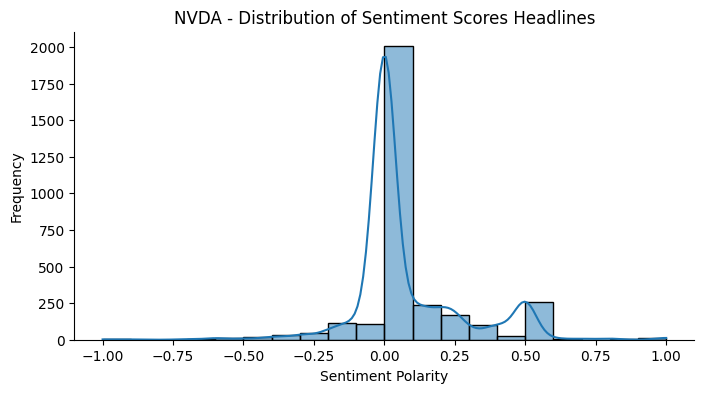

In [89]:
#plot the distribution of sentiment scores
plt.figure(figsize=(8, 4))
sns.histplot(NVDA_df['sentiment'], bins=20, kde=True)
plt.title('NVDA - Distribution of Sentiment Scores Headlines')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.gca().spines[['top', 'right']].set_visible(False)


#select plot directory and plot name to save plot
plot_folder = 'C:/Users/nuhamin/Documents/kifiya/week 1/' \
'Stock-Market-Price-Prediction-with-Sentiment-Analysis/' \
'plot images/news plot'

plot_name = 'NVDA - Distribution of Sentiment Scores Headlines.png'
plot_path = os.path.join(plot_folder, plot_name)

#create the directory if it doesn't exist
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)

#save plot and display message
plt.savefig(plot_path)
print(f'\nPlot is saved.\n')

#display the plot
plt.show()

#close the plot to free up memory
plt.close()

## Text Analysis (Topic Modelling)

In [90]:
#preproces dataframe
  #Converting to lowercase.
  #Removing non-alphanumeric characters (except spaces).
  #Tokenizing the text into words.
  #Removing common English stop words.
  #Lemmatizing words to their base form.

NVDA_text_data = NVDA_df['headline'].dropna().tolist() 

def preprocess_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char.isalnum() or char.isspace()]) #keep alphanumeric and spaces
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

processed_NVDA_text_data = [preprocess_text(text) for text in NVDA_text_data]

In [91]:
#calculate Term Frequency-Inverse Document Frequency (TF-IDF) to identify important terms

#initalise tfidf_vectorizer for upto 1000 single words and two-word phrases 
tfidf_vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2)) #consider unigrams and bigrams

#calculate tfidf_matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(processed_NVDA_text_data)

#get feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

#iterate through each articles to find overall important terms
#terms with highest TF-IDF scores across all documents
print('\nTop TF-IDF terms:\n')

#calculate Average TF-IDF scores
#'.A1' converts the result matrix of means into a 1-dimensional array
average_tfidf = tfidf_matrix.mean(axis=0).A1

#sort and get top terms
sorted_tfidf_indices = average_tfidf.argsort()[::-1]
top_tfidf_terms = [(feature_names[i], average_tfidf[i]) for i in sorted_tfidf_indices[:20]] #top 20
for term, score in top_tfidf_terms:
    print(f'{term}: {score:.4f}')


Top TF-IDF terms:

nvidia: 0.0604
stock: 0.0341
market: 0.0218
share: 0.0217
earnings: 0.0202
price: 0.0176
top: 0.0174
target: 0.0172
semiconductor: 0.0157
price target: 0.0156
amd: 0.0154
benzingas: 0.0148
upgrade: 0.0137
report: 0.0136
raise: 0.0128
maintains: 0.0127
buy: 0.0127
nvda: 0.0125
benzingas top: 0.0123
nvidias: 0.0121


In [92]:
#topic Modeling with LDA
num_topics = 10
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(tfidf_matrix)

print(f'\nTopics discovered by LDA ({num_topics} topics):')
for index, topic in enumerate(lda.components_):
    print(f'Topic #{index + 1}:')
    top_words = [feature_names[i] for i in topic.argsort()[-10:]] #get top 10 words for each topic
    print(', '.join(top_words))


Topics discovered by LDA (10 topics):
Topic #1:
pick, peek market, peek, street, nvidias, stock, ahead, stock future, market, future
Topic #2:
august, gainer, benzingas top, benzingas, top, hit, minute, stock, market minute, etf
Topic #3:
buy nvidia, buy, raise price, maintains, nvidia raise, raise, price target, price, target, nvidia
Topic #4:
amd, price target, price, gaming, target, nvidia, target change, biggest price, biggest, change
Topic #5:
watch, cramer, downgrade, stock watch, stock, upgrade, top upgrade, benzingas, benzingas top, top
Topic #6:
sweep, graphic, oi, ask, nvidia, amd, call, alert, option alert, option
Topic #7:
earnings, trading higher, several, higher, stock, apple, share, trading, company, semiconductor
Topic #8:
upgrade nvidia, downgrade nvidia, premarket session, stock, premarket, session, stock moving, nvidia, moving, pt
Topic #9:
earnings, eps, q4, revenue, q3, see, est, sale, report, nvidia
Topic #10:
market update, update, earnings, capital, beat, analy

In [93]:
#named Entity Recognition with spaCy
print('\nNamed Entities (using spaCy - for the first 10 articles):\n')
for i, text in enumerate(NVDA_text_data[:10]): #process 10 
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    if entities:
        print(f'Article {i + 1}: {entities}')
    else:
        print(f'Article {i + 1}: No named entities found.')


Named Entities (using spaCy - for the first 10 articles):

Article 1: [('US', 'GPE')]
Article 2: [('5 Minutes', 'TIME')]
Article 3: [('5 Minutes', 'TIME')]
Article 4: No named entities found.
Article 5: [('5 Minutes', 'TIME')]
Article 6: [('this year', 'DATE')]
Article 7: [('5 Minutes', 'TIME')]
Article 8: [('AMD', 'ORG'), ('Nvidia', 'GPE')]
Article 9: [('Ciena', 'ORG'), ('Harley-Davidson', 'ORG')]
Article 10: [('Lobby', 'PERSON'), ('Boost U.S. Manufacturing', 'ORG')]


## Time Series Analysis


Plot is saved.



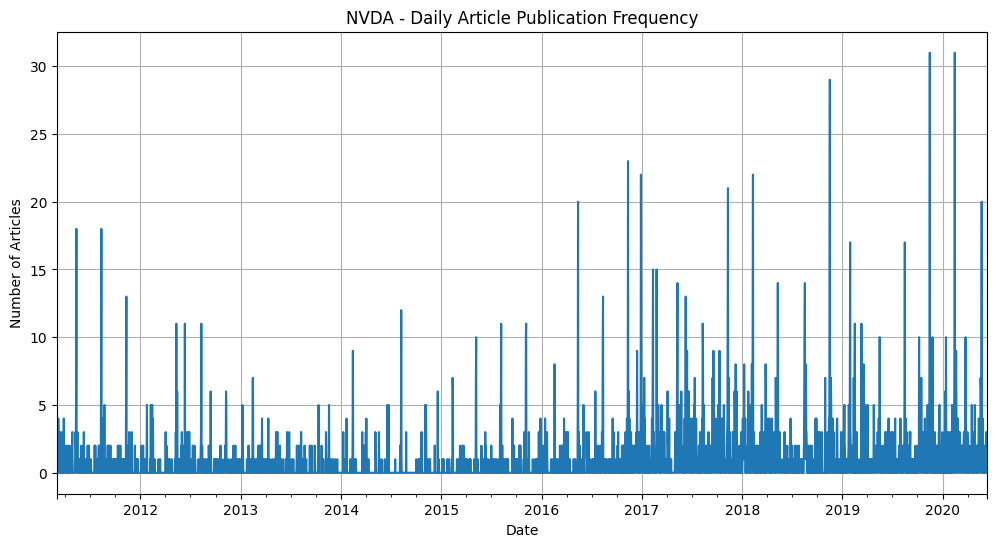

In [94]:
#plot and save the daily publication frequency

#resample to daily frequency and count publications
daily_publications = NVDA_df.resample('D', on='date').size()

#plot
plt.figure(figsize=(12, 6))
daily_publications.plot()
plt.title('NVDA - Daily Article Publication Frequency')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.grid()


#select plot directory and plot name to save plot image
plot_folder = 'C:/Users/nuhamin/Documents/kifiya/week 1/' \
'Stock-Market-Price-Prediction-with-Sentiment-Analysis/' \
'plot images/news plot'

plot_name = 'NVDA - Daily Article Publication Frequency.png'
plot_path = os.path.join(plot_folder, plot_name)

#create the directory if it doesn't exist
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)

#save plot and display message
plt.savefig(plot_path)
print(f'\nPlot is saved.\n')

#display the plot
plt.show()

#close the plot to free up memory
plt.close()


Number of articles published at 00:00 is 3136


Plot is saved.



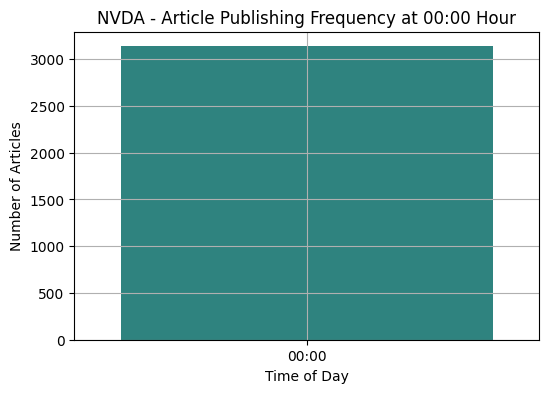

In [95]:
#plot and save the hourly publication frequency for 00:00 hour

#extract the hour from the datetime column
NVDA_df['publish_hour'] = pd.to_datetime(NVDA_df['date']).dt.hour

#filter data for 00:00
zero_hour_data = NVDA_df[NVDA_df['publish_hour'] == 0]

#calculate and print the count of articles published at 00:00
zero_hour_count = len(zero_hour_data)
print(f'\nNumber of articles published at 00:00 is {zero_hour_count}\n')

#plot for 00:00
#Create a small DataFrame 
plot_data = pd.DataFrame({'hour': ['00:00'], 'count': [zero_hour_count]})

plt.figure(figsize=(6, 4))
sns.barplot(x='hour', y='count', data=plot_data, hue='hour', palette='viridis', legend=False)
plt.title('NVDA - Article Publishing Frequency at 00:00 Hour')
plt.xlabel('Time of Day')
plt.ylabel('Number of Articles')
plt.grid()


#select plot directory and plot name to save plot image
plot_folder = 'C:/Users/nuhamin/Documents/kifiya/week 1/' \
'Stock-Market-Price-Prediction-with-Sentiment-Analysis/' \
'plot images/news plot'

plot_name = 'NVDA - Article Publishing Frequency at 00 00 Hour.png'
plot_path = os.path.join(plot_folder, plot_name)

#create the directory if it doesn't exist
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)

#save plot and display message
plt.savefig(plot_path)
print(f'\nPlot is saved.\n')

#display the plot
plt.show()

#close the plot to free up memory
plt.close()


Plot is saved.



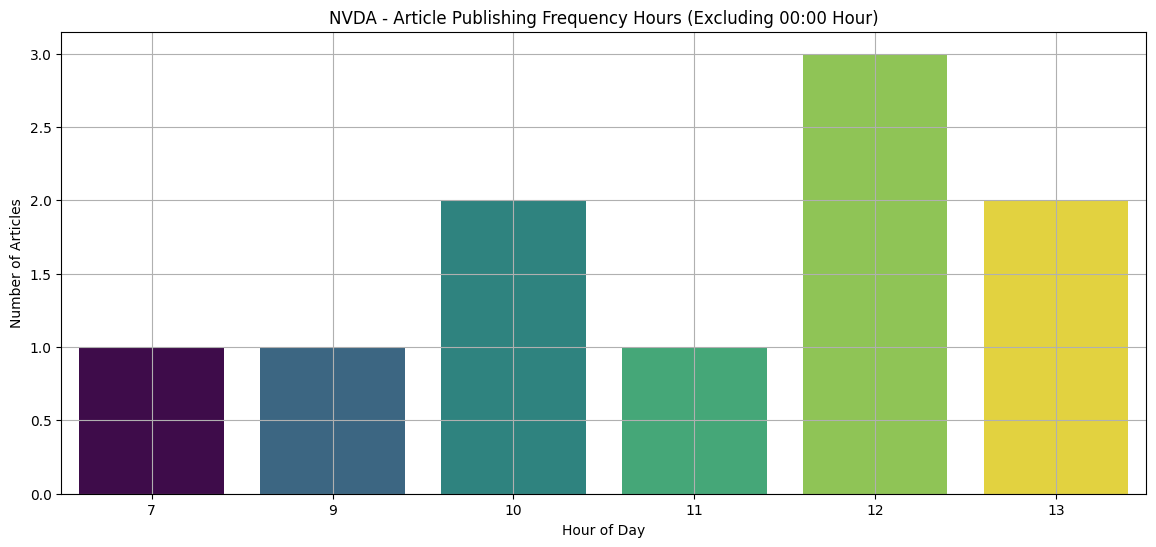

In [96]:
#plot and save the hourly publication frequency for hour other than 00:00 

#filter data for all other times
other_hours_data = NVDA_df[NVDA_df['publish_hour'] != 0]

#plot for 00:00
#Count articles per hour for other times
hourly_counts = other_hours_data['publish_hour'].value_counts().sort_index()

#plot
plt.figure(figsize=(14, 6))
sns.barplot(x=hourly_counts.index, y=hourly_counts.values, 
            hue=hourly_counts.index, palette='viridis', legend=False)
plt.title('NVDA - Article Publishing Frequency Hours (Excluding 00:00 Hour)')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Articles')
plt.xticks()
plt.grid() 


#select plot directory and plot name to save plot image
plot_folder = 'C:/Users/nuhamin/Documents/kifiya/week 1/' \
'Stock-Market-Price-Prediction-with-Sentiment-Analysis/' \
'plot images/news plot'

plot_name = 'NVDA - Article Publishing Frequency Hours (Excluding 00 00 Hour).png'
plot_path = os.path.join(plot_folder, plot_name)

#create the directory if it doesn't exist
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)

#save plot and display message
plt.savefig(plot_path)
print(f'\nPlot is saved.\n')

#display the plot
plt.show()

#close the plot to free up memory
plt.close()

## Publisher Analysis

In [97]:
#sentiment in the type of news specific publishers report

#analyse sentiment by publisher
sentiment_by_publisher = NVDA_df.groupby('publisher')['sentiment'].mean()
print('\nAverage sentiment by publisher:\n')
print(sentiment_by_publisher)


Average sentiment by publisher:

publisher
Abe Raymond                  0.000000
Alex Cho                     0.000000
Alex Furno                   0.140000
Ali Berri                    0.000000
Allie Wickman                0.053139
                               ...   
luke@benzinga.com            0.114746
optionsXpress               -0.033333
vishwanath@benzinga.com      0.000000
vivek.proactive@gmail.com    0.000000
webmaster                    0.018939
Name: sentiment, Length: 152, dtype: float64


In [98]:
#identify unique domains to check if  publisher is email adress instead of name
#extract the domain from each email address in the 'publisher' column
NVDA_df['domain'] = NVDA_df['publisher'].apply(lambda x: x.split('@')[-1] if '@' in x else 'Not an email')

#count the occurrences of each unique domain
domain_counts = NVDA_df['domain'].value_counts()

#display the domains with the highest counts (excluding 'Not an email' if it exists)
print('\nDomains with the most contributions:\n')
print(domain_counts[domain_counts.index != 'Not an email'].head())


Domains with the most contributions:

domain
benzinga.com    23
gmail.com        1
Name: count, dtype: int64


# **TSLA** #

In [99]:
#assign df to a variable and display head
TSLA_df = stock_dfs['TSLA']
TSLA_df.head()

,date,headline,publisher,stock,url,sentiment
0,2020-06-10 17:02:47-04:00,Tesla's Stock Closes At All-Time High As Musk ...,Drew Levine,TSLA,https://www.benzinga.com/news/20/06/16225150/t...,0.193636
1,2020-06-10 15:08:09-04:00,'Tesla factory workplace safety is 5% better t...,Benzinga Newsdesk,TSLA,https://www.benzinga.com/news/20/06/16225621/t...,0.183333
2,2020-06-10 12:41:58-04:00,'Tesla hacker unlocks Performance upgrade and ...,Benzinga Newsdesk,TSLA,https://www.benzinga.com/news/20/06/16224205/t...,0.000000
3,2020-06-10 11:33:18-04:00,GM On Track To Spend $20B On EV And AV Develop...,Benzinga Newsdesk,TSLA,https://www.benzinga.com/news/20/06/16223414/g...,0.000000
4,2020-06-10 10:15:07-04:00,"Tesla's Journey To $1,000 In 2020",Wayne Duggan,TSLA,https://www.benzinga.com/news/20/06/16222035/t...,0.000000


## Descriptive Statistics

In [100]:
#display descriptive statistics for the 'headline' column
print("Descriptive statistics for 'headline' column:")
print(TSLA_df['headline'].describe())

#get the number of unique headlines
print("\nNumber of unique headlines:")
print(TSLA_df['headline'].nunique())

#calculate headline length
TSLA_df['headline_length'] = TSLA_df['headline'].apply(len)
print("\nBasic statistics for 'headline_length' column:")
print(TSLA_df['headline_length'].describe())

#display the most frequent headlines
print("\nMost frequent headlines:")
print(TSLA_df['headline'].value_counts().head())

Descriptive statistics for 'headline' column:
count                                             1875
unique                                            1827
top       10 Biggest Price Target Changes For Thursday
freq                                                 8
Name: headline, dtype: object

Number of unique headlines:
1827

Basic statistics for 'headline_length' column:
count    1875.000000
mean       87.247467
std        47.142165
min        19.000000
25%        60.000000
50%        75.000000
75%        95.000000
max       337.000000
Name: headline_length, dtype: float64

Most frequent headlines:
headline
10 Biggest Price Target Changes For Thursday                           8
10 Biggest Price Target Changes For Wednesday                          6
Morning Market Stats in 5 Minutes                                      5
10 Consumer Cyclical Stocks Moving In Thursday's Pre-Market Session    3
5 Consumer Cyclical Stocks Moving In Friday's Pre-Market Session       3
Name: count, dty

In [101]:
#count the number of articles per publisher 
print('Number of articles per publisher:\n')
print(TSLA_df['publisher'].value_counts())

Number of articles per publisher:

publisher
Benzinga Newsdesk          641
Charles Gross              188
Lisa Levin                 173
Benzinga_Newsdesk          102
Neer Varshney               85
Wayne Duggan                64
FreightWaves                56
JJ Kinahan                  53
IAM Newswire                47
Shivdeep Dhaliwal           44
Dave Royse                  43
Vick Meyer                  35
Shanthi Rexaline            34
Jayson Derrick              34
Tanzeel Akhtar              32
Elizabeth Balboa            32
Nelson Hem                  32
Craig Jones                 17
ETF Professor               14
Joel Elconin                13
Renato Capelj               12
luke@benzinga.com           11
Benzinga Insights           11
Chris Dier-Scalise          11
TD Ameritrade Network        9
Spencer Israel               8
Amit Nag                     7
TD Ameritrade                7
Jason Shubnell               6
Sebastian Brown              6
Tyree Gorges             


Publication trends by day of the week:
publication_day
Wednesday    434
Thursday     419
Tuesday      351
Monday       302
Friday       285
Saturday      49
Sunday        35
Name: count, dtype: int64

Plot is saved.



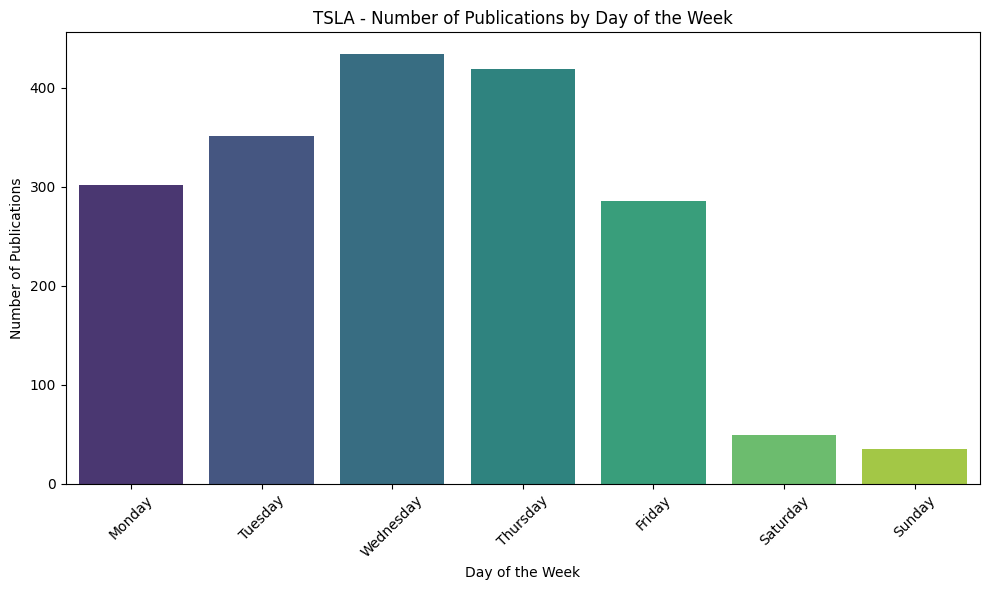

In [102]:
#analyse publication dates
TSLA_df['publication_day'] = TSLA_df['date'].dt.day_name()
print("\nPublication trends by day of the week:")
print(TSLA_df['publication_day'].value_counts())

#plot publication dates and save plot image 
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
publication_day_counts = TSLA_df['publication_day'].value_counts().reindex(day_order)

plt.figure(figsize=(10, 6))
sns.barplot(x=publication_day_counts.index, y=publication_day_counts.values, 
            hue=publication_day_counts.index, palette='viridis', legend=False)
plt.title('TSLA - Number of Publications by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Publications')
plt.xticks(rotation=45)
plt.tight_layout()

#select plot directory and plot name to save plot
plot_folder = 'C:/Users/nuhamin/Documents/kifiya/week 1/' \
'Stock-Market-Price-Prediction-with-Sentiment-Analysis/' \
'plot images/news plot'

plot_name = 'TSLA - Number of Publications by Day of the Week.png'
plot_path = os.path.join(plot_folder, plot_name)

#create the directory if it doesn't exist
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)

#save plot and display message
plt.savefig(plot_path)
print(f'\nPlot is saved.\n')

#display the plot
plt.show()

#close the plot to free up memory
plt.close()

## Sentiment Analysis

In [103]:

#calculate distribution of sentiment scores
print('Sentiment distribution:')
print(TSLA_df['sentiment'].describe())

#analyse the sentiment of the most positive and negative headlines
#most positive headlines
most_positive_headlines = TSLA_df.nlargest(5, 'sentiment')
print("\nMost Positive Headlines:")
print(most_positive_headlines[['headline', 'sentiment']])

#most negative headlines
most_negative_headlines = TSLA_df.nsmallest(5, 'sentiment')
print("\nMost Negative Headlines:")
print(most_negative_headlines[['headline', 'sentiment']])

Sentiment distribution:
count    1875.000000
mean        0.061557
std         0.204869
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.123611
max         1.000000
Name: sentiment, dtype: float64

Most Positive Headlines:
                                               headline  sentiment
174   Electreck.Co Says Tesla Modle 3 Was The Best S...        1.0
942   This Might Be The Best Song Ever Written About...        1.0
1218  'Tesla Supercharger network reaches 15,000 cha...        1.0
1250  Tesla Model 3 Named 'Best Electric Car' By Edm...        1.0
1615  Today's Pickup: Elon And Jeff: The Best Of Ene...        1.0

Most Negative Headlines:
                                               headline  sentiment
108   'Elon Musk's Boring Company completes excavati...       -1.0
405   'Tesla reveals insane $172,000 Powerpack price...       -1.0
601   Worst Of The Worst: Losses Accelerate Into Clo...       -1.0
762   Musk On Tesla Founder Martin Eberhard: 'He Is ..


Plot is saved.



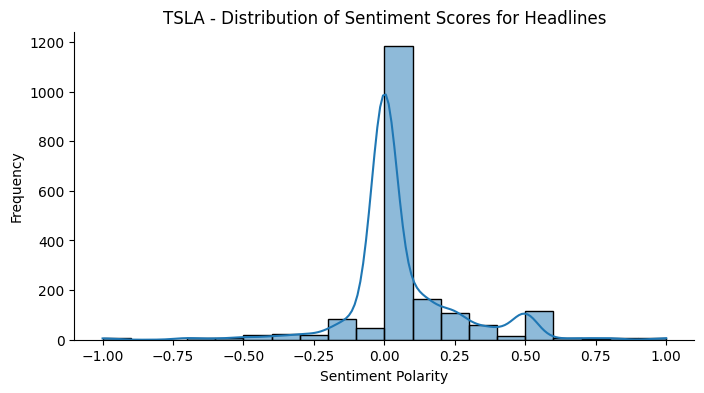

In [104]:
#plot the distribution of sentiment scores
plt.figure(figsize=(8, 4))
sns.histplot(TSLA_df['sentiment'], bins=20, kde=True)
plt.title('TSLA - Distribution of Sentiment Scores for Headlines')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.gca().spines[['top', 'right']].set_visible(False)


#select plot directory and plot name to save plot image
plot_folder = 'C:/Users/nuhamin/Documents/kifiya/week 1/' \
'Stock-Market-Price-Prediction-with-Sentiment-Analysis/' \
'plot images/news plot'

plot_name = 'TSLA - Distribution of Sentiment Scores for Headlines.png'
plot_path = os.path.join(plot_folder, plot_name)

#create the directory if it doesn't exist
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)

#save plot and display message
plt.savefig(plot_path)
print(f'\nPlot is saved.\n')

#display the plot
plt.show()

#close the plot to free up memory
plt.close()

## Text Analysis (Topic Modelling)

In [105]:
#preproces dataframe
  #Converting to lowercase.
  #Removing non-alphanumeric characters (except spaces).
  #Tokenizing the text into words.
  #Removing common English stop words.
  #Lemmatizing words to their base form.

TSLA_text_data = TSLA_df['headline'].dropna().tolist() 

def preprocess_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char.isalnum() or char.isspace()]) #keep alphanumeric and spaces
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

processed_TSLA_text_data = [preprocess_text(text) for text in TSLA_text_data]

In [106]:
#calculate Term Frequency-Inverse Document Frequency (TF-IDF) to identify important terms

#initalise tfidf_vectorizer for upto 1000 single words and two-word phrases 
tfidf_vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2)) #consider unigrams and bigrams

#calculate tfidf_matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(processed_TSLA_text_data)

#get feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

#iterate through each articles to find overall important terms
#terms with highest TF-IDF scores across all documents
print('\nTop TF-IDF terms:\n')

#calculate Average TF-IDF scores
#'.A1' converts the result matrix of means into a 1-dimensional array
average_tfidf = tfidf_matrix.mean(axis=0).A1

#sort and get top terms
sorted_tfidf_indices = average_tfidf.argsort()[::-1]
top_tfidf_terms = [(feature_names[i], average_tfidf[i]) for i in sorted_tfidf_indices[:20]] #top 20
for term, score in top_tfidf_terms:
    print(f'{term}: {score:.4f}')


Top TF-IDF terms:

tesla: 0.0683
stock: 0.0287
musk: 0.0260
say: 0.0242
model: 0.0228
price: 0.0210
elon: 0.0203
electrek: 0.0202
elon musk: 0.0200
share: 0.0195
target: 0.0183
china: 0.0175
market: 0.0163
price target: 0.0160
session: 0.0147
new: 0.0146
car: 0.0144
tesla share: 0.0143
report: 0.0140
delivery: 0.0136


In [107]:
#topic Modeling with LDA
num_topics = 10
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(tfidf_matrix)

print(f'\nTopics discovered by LDA ({num_topics} topics):')
for index, topic in enumerate(lda.components_):
    print(f'Topic #{index + 1}:')
    top_words = [feature_names[i] for i in topic.argsort()[-10:]] #get top 10 words for each topic
    print(', '.join(top_words))


Topics discovered by LDA (10 topics):
Topic #1:
mover yesterday, peek, biggest, yesterday, biggest mover, mover, option, earnings, future, market
Topic #2:
vehicle, lower, trading higher, stock, higher, tesla, share trading, tesla share, trading, share
Topic #3:
solar, electrek, say, high, new, tweet, tesla, elon musk, elon, musk
Topic #4:
sale, tesla model, tesla, electric car, industry, electric, today pickup, today, pickup, car
Topic #5:
stanley, morgan, tesla, tesla raise, maintains, raise price, raise, price target, price, target
Topic #6:
twitter, benzingas, apple, bear week, tesla, bull bear, 2020, bull, bear, week
Topic #7:
cyclical, cyclical stock, consumer cyclical, consumer, premarket, premarket session, stock, stock moving, moving, session
Topic #8:
order, model, gigafactory, year, factory, fremont, electrek, california, say, tesla
Topic #9:
plan, vehicle, chinamade model, sell, chinamade, tesla say, say, china, model, tesla
Topic #10:
report, cramer, short, elon musk, elo

In [108]:
#named Entity Recognition with spaCy
print('\nNamed Entities (using spaCy - for the first 10 articles):\n')
for i, text in enumerate(TSLA_text_data[:10]): #process 10 
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    if entities:
        print(f'Article {i + 1}: {entities}')
    else:
        print(f'Article {i + 1}: No named entities found.')


Named Entities (using spaCy - for the first 10 articles):

Article 1: [("Tesla's Stock Closes", 'ORG')]
Article 2: [('Tesla', 'NORP'), ('5%', 'PERCENT'), ('manufacturers &', 'ORG'), ('Elon Musk', 'PERSON')]
Article 3: [('Tesla', 'NORP')]
Article 4: [('GM', 'ORG'), ('20B', 'MONEY'), ('EV', 'ORG'), ('AV Development', 'ORG'), ('2025', 'DATE')]
Article 5: [('Tesla', 'ORG'), ('Journey To $1,000', 'MONEY'), ('2020', 'DATE')]
Article 6: [('Mark Session', 'PERSON'), ('1,000', 'MONEY')]
Article 7: [('Wedbush', 'ORG'), ("Tesla Has '", 'PERSON'), ('1,000', 'MONEY')]
Article 8: [('Wedbush Maintains Neutral', 'ORG'), ('Raises Price Target', 'ORG'), ('1000', 'MONEY')]
Article 9: No named entities found.
Article 10: [('Wedbush', 'ORG'), ('$800 to $1000', 'MONEY')]


## Time Series Analysis


Plot is saved.



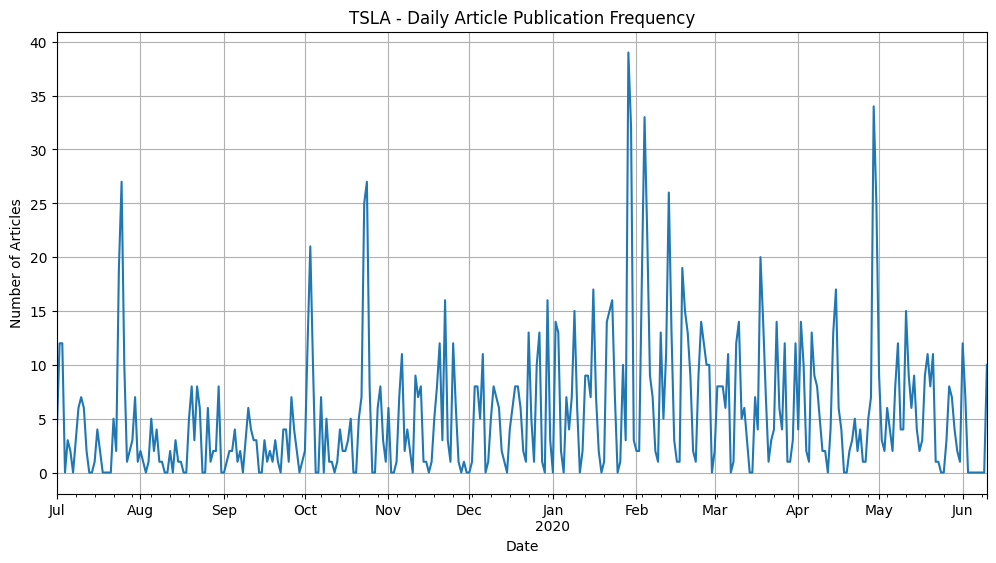

In [109]:
#plot and save the daily publication frequency

#resample to daily frequency and count publications
daily_publications = TSLA_df.resample('D', on='date').size()

#plot
plt.figure(figsize=(12, 6))
daily_publications.plot()
plt.title('TSLA - Daily Article Publication Frequency')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.grid()


#select plot directory and plot name to save plot image
plot_folder = 'C:/Users/nuhamin/Documents/kifiya/week 1/' \
'Stock-Market-Price-Prediction-with-Sentiment-Analysis/' \
'plot images/news plot'

plot_name = 'TSLA - Daily Article Publication Frequency.png'
plot_path = os.path.join(plot_folder, plot_name)

#create the directory if it doesn't exist
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)

#save plot and display message
plt.savefig(plot_path)
print(f'\nPlot is saved.\n')

#display the plot
plt.show()

#close the plot to free up memory
plt.close()


Number of articles published at 00:00 is 1865


Plot is saved.



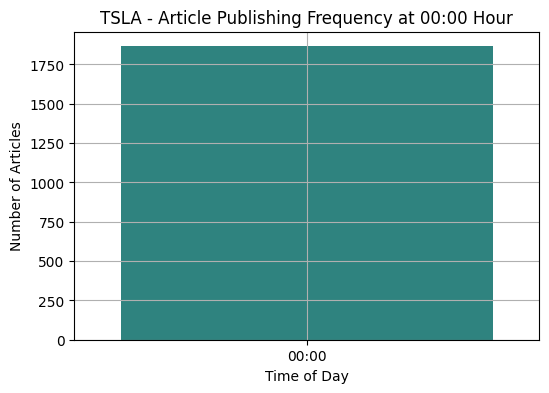

In [110]:
#plot and save the hourly publication frequency for 00:00 hour

#extract the hour from the datetime column
TSLA_df['publish_hour'] = pd.to_datetime(TSLA_df['date']).dt.hour

#filter data for 00:00
zero_hour_data = TSLA_df[TSLA_df['publish_hour'] == 0]

#calculate and print the count of articles published at 00:00
zero_hour_count = len(zero_hour_data)
print(f'\nNumber of articles published at 00:00 is {zero_hour_count}\n')

#plot for 00:00
#Create a small DataFrame 
plot_data = pd.DataFrame({'hour': ['00:00'], 'count': [zero_hour_count]})

plt.figure(figsize=(6, 4))
sns.barplot(x='hour', y='count', data=plot_data, hue='hour', palette='viridis', legend=False)
plt.title('TSLA - Article Publishing Frequency at 00:00 Hour')
plt.xlabel('Time of Day')
plt.ylabel('Number of Articles')
plt.grid()


#select plot directory and plot name to save plot image
plot_folder = 'C:/Users/nuhamin/Documents/kifiya/week 1/' \
'Stock-Market-Price-Prediction-with-Sentiment-Analysis/' \
'plot images/news plot'

plot_name = 'TSLA - Article Publishing Frequency at 00 00 Hour.png'
plot_path = os.path.join(plot_folder, plot_name)

#create the directory if it doesn't exist
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)

#save plot and display message
plt.savefig(plot_path)
print(f'\nPlot is saved.\n')

#display the plot
plt.show()

#close the plot to free up memory
plt.close()


Plot is saved.



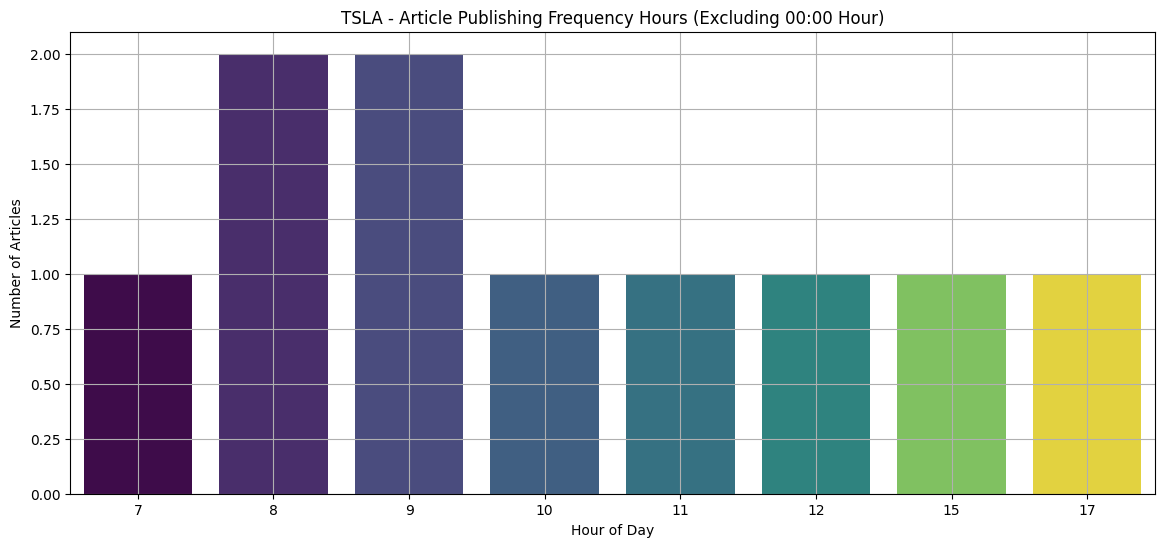

In [111]:
#plot and save the hourly publication frequency for hour other than 00:00 

#filter data for all other times
other_hours_data = TSLA_df[TSLA_df['publish_hour'] != 0]

#plot for 00:00
#Count articles per hour for other times
hourly_counts = other_hours_data['publish_hour'].value_counts().sort_index()

#plot
plt.figure(figsize=(14, 6))
sns.barplot(x=hourly_counts.index, y=hourly_counts.values, 
            hue=hourly_counts.index, palette='viridis', legend=False)
plt.title('TSLA - Article Publishing Frequency Hours (Excluding 00:00 Hour)')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Articles')
plt.xticks()
plt.grid() 


#select plot directory and plot name to save plot image
plot_folder = 'C:/Users/nuhamin/Documents/kifiya/week 1/' \
'Stock-Market-Price-Prediction-with-Sentiment-Analysis/' \
'plot images/news plot'

plot_name = 'TSLA - Article Publishing Frequency Hours (Excluding 00 00 Hour).png'
plot_path = os.path.join(plot_folder, plot_name)

#create the directory if it doesn't exist
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)

#save plot and display message
plt.savefig(plot_path)
print(f'\nPlot is saved.\n')

#display the plot
plt.show()

#close the plot to free up memory
plt.close()

## Publisher Analysis

In [112]:
#sentiment in the type of news specific publishers report

#analyse sentiment by publisher
sentiment_by_publisher = TSLA_df.groupby('publisher')['sentiment'].mean()
print('\nAverage sentiment by publisher:\n')
print(sentiment_by_publisher)


Average sentiment by publisher:

publisher
Amit Nag                   0.054762
Benzinga Cannabis          0.000000
Benzinga Insights          0.000000
Benzinga Newsdesk          0.076600
Benzinga_Newsdesk          0.030405
Benzinga Newsdesk          0.112500
Brent Slava                0.000000
Brett Hershman             0.000000
Bryce Matulonis           -0.375000
Catherine Ross             0.096591
Charles Gross              0.031212
Chris Dier-Scalise         0.001768
Craig Adeyanju             0.000000
Craig Jones                0.191765
Dave Royse                 0.074688
Drew Levine                0.193636
Dustin Blitchok            0.000000
Dylan Wittenberg           0.000000
ETF Professor              0.190043
Elizabeth Balboa           0.040483
FreightWaves               0.103274
Hal Lindon                 0.250000
Henry Khederian            0.300000
IAM Newswire               0.029282
JJ Kinahan                -0.024266
Jason Raznick              0.000000
Jason Shubnell      

In [113]:
#identify unique domains to check if  publisher is email adress instead of name
#extract the domain from each email address in the 'publisher' column
TSLA_df['domain'] = TSLA_df['publisher'].apply(lambda x: x.split('@')[-1] if '@' in x else 'Not an email')

#count the occurrences of each unique domain
domain_counts = TSLA_df['domain'].value_counts()

#display the domains with the highest counts (excluding 'Not an email' if it exists)
print('\nDomains with the most contributions:\n')
print(domain_counts[domain_counts.index != 'Not an email'].head())


Domains with the most contributions:

domain
benzinga.com    12
Name: count, dtype: int64


# Save Processed Data

In [114]:
#save dataframes to repo folder
#define directory path
output_dir = 'C:/Users/nuhamin/Documents/kifiya/week 1/' \
'Stock-Market-Price-Prediction-with-Sentiment-Analysis/' \
'data/sentiment_data'

#create directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#map stock symbols to their dataFrames using dictionary
stock_dataframes = {'AAPL': stock_dfs['AAPL'].sort_index(axis=1),
                    'AMZN': stock_dfs['AMZN'].sort_index(axis=1),
                    'GOOG': stock_dfs['GOOG'].sort_index(axis=1),
                    'META': stock_dfs['FB'].sort_index(axis=1),
                    'MSFT': stock_dfs['MSF'].sort_index(axis=1),
                    'NVDA': stock_dfs['NVDA'].sort_index(axis=1),
                    'TSLA': stock_dfs['TSLA'].sort_index(axis=1),}

#save each dataFrame to a separate CSV file
for symbol, df in stock_dataframes.items():
    output_file_path = os.path.join(output_dir, f'{symbol}_sentiment_data.csv')
    df.to_csv(output_file_path, index=False)

print('DataFrames are saved to CSV files.')

DataFrames are saved to CSV files.
